# Regression Model to pick Stamp Duty applicable to a given property

The purpose of this notebook is to showcase my skills in:

- Analytics
  - Data collection
  - Data cleaning and preprocessing
  - Data visualisation
  - Modelling


- Programming
  - Proficiency with Python and PyData stack
  - Code readability and commenting
  - Problem solving


- Data / Business Understanding
  - Exhibit ability to understand an unfamiliar area
  - Interpretation of findings


In [1]:
# Installing additional packages used by me
!pip install sweetviz
!pip install plotly
!pip install lime

In [2]:
import pandas as pd
import numpy as np
import re
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline
plt.style.use('bmh')

### Case Study

For this case study is for the Irish Revenue. Using the data specified below, the Revenue require 3 primary objectives to be addressed:

1. Perform an exploratory data analysis to highlight interesting patterns in the data.
2. Identify residential sales which seem unusual i.e. residential sales which are unusually high or low considering the available features.
3. Provide your opinion on whether a model can reliably forecast monthly stamp duty. [Stamp duty](https://www.revenue.ie/en/property/stamp-duty/property/index.aspx) is a tax applied to the sale of property. For the purpose of this,I am assuming stamp duty is charged on all sales (exclusive of 13.5% VAT) at a rate of 1%.

The below formula is how to calculate stamp duty:

$$
\text{Stamp Duty Due} = \text{Stamp Duty Rate} \times (\text{Sale Price}-(\text{Sale Price} \times \text{VAT}))
$$


$$
\text{Stamp Duty Due} = 0.01 \times (\text{Sale Price}-(\text{Sale Price} \times 0.135))
$$

#### Data

1. [Residential Property Price Register](https://www.propertypriceregister.ie/)
2. [Residential Property Price Index](https://data.cso.ie/table/HPM09) - [Data description](https://www.cso.ie/en/methods/surveybackgroundnotes/residentialpropertypriceindex/#:~:text=The%20Residential%20Property%20Price%20Index,residential%20properties%20sold%20in%20Ireland.&text=The%20index%20is%20mix%2Dadjusted,are%20sold%20in%20different%20months.)

Before beginning, make sure to visit the provided links to gain a better understanding of the data.

Please read through entire assessment before beginning.

##### 1. Download and load datasets

The first step to perform is to download and read the data by following the below steps.

- **Property Prices**
  - Visit [link](https://www.propertypriceregister.ie/) and download all data using "DOWNLOAD ALL" button
  - Unzip `PPR-ALL.zip` and load `PPR-ALL.csv` into a pandas DataFrame.Following columns will be used:

`Date of Sale (dd/mm/yyyy)`, `Address`, `County`, `Price ()`, `VAT Exclusive`, `Not Full Market Price`, `Description of Property`

- **Residential Price Index (RPI)**
  - Visit [link](https://data.cso.ie/table/HPM09) and download all data as a CSV. File will download with the following name `HPM09.<time_of_download>.csv`
  - Load `HPM09.<time_of_download>.csv` into a pandas DataFrame

In [3]:
#loading property price dataset, we need to mention encoding here to avoid any error
df_pp1 = pd.read_csv('PPR-ALL.csv',encoding='ISO-8859-1')
print(df_pp1.shape)
# Picking up the columns specified in the description above
df_property_price = df_pp1[['Date of Sale (dd/mm/yyyy)', 'Address', 'County', 'Price ()', 'VAT Exclusive', 'Not Full Market Price', 'Description of Property']]
print(df_property_price.shape)
df_property_price.head()

(482126, 9)
(482126, 7)


Date of Sale (dd/mm/yyyy)                                         Address  \
0                01/01/2010          5 Braemor Drive, Churchtown, Co.Dublin   
1                03/01/2010  134 Ashewood Walk, Summerhill Lane, Portlaoise   
2                04/01/2010             1 Meadow Avenue, Dundrum, Dublin 14   
3                04/01/2010                         1 The Haven, Mornington   
4                04/01/2010                   11 Melville Heights, Kilkenny   

     County    Price () VAT Exclusive Not Full Market Price  \
0    Dublin  343,000.00            No                    No   
1     Laois  185,000.00           Yes                    No   
2    Dublin  438,500.00            No                    No   
3     Meath  400,000.00            No                    No   
4  Kilkenny  160,000.00            No                    No   

                 Description of Property  
0  Second-Hand Dwelling house /Apartment  
1          New Dwelling house /Apartment  
2  Second-Hand Dwelling house /Apartment  
3  Second-Hand Dwelling house /Apartment  
4  Second-Hand Dwelling house /Apartment

In [4]:
# Loading the residential price index

df_residential_price_index = pd.read_csv('HPM09.20210713T210753.csv')
print(df_residential_price_index.shape)
df_residential_price_index.head()

(15680, 5)


Statistic    Month  \
0  Residential Property Price Index  2005M01   
1  Residential Property Price Index  2005M01   
2  Residential Property Price Index  2005M01   
3  Residential Property Price Index  2005M01   
4  Residential Property Price Index  2005M01   

            Type of Residential Property           UNIT  VALUE  
0  National - all residential properties  Base 2015=100  124.9  
1                      National - houses  Base 2015=100  120.7  
2                  National - apartments  Base 2015=100  153.4  
3    Dublin - all residential properties  Base 2015=100  118.5  
4                        Dublin - houses  Base 2015=100  112.0

##### 2. Data Cleaning & Processing

Next, complete the following steps to obtain the dataset which the exploratory analysis will be performed on. 

Note, perform any additional steps that may be warranted based on your understanding of the data that you have observed from the data itself and/or from the information provided in the links.

- **Property Price Data Cleaning**
  - For the assessment I am using data from 2010 to 2019 (inclusive). Print length of DataFrame.
  - Filter out all counties except for the following `Dublin`, `Cork`, `Galway`, `Kildare` and `Meath`. Print length of DataFrame.


- **RPI Data Cleaning**
  - For the assessment I am using data from 2010 to 2019 (inclusive). Print length of DataFrame.
  - Include only `Residential Property Price Index` statistic. Print length of DataFrame.
  - Remove type of residential properties that are not either `Dublin - all residential properties` or `National excluding Dublin - all residential properties`.


- **Combine Data**
  - Combine both data sources in such a way that type of residential properties categorisations are aligned appropriately
  - Estimate sale prices so that they are all comparable to December 2019 prices by using the RPI information

**1. Property Price Data Cleaning**

In [5]:
# Property price data cleaning
print('Shape of Property price data before applying filter: ' + str(df_property_price.shape))
df_property_price['Date of Sale (dd/mm/yyyy)'] = pd.to_datetime(df_property_price['Date of Sale (dd/mm/yyyy)'], format='%d/%m/%Y')

df_property_price = df_property_price[df_property_price['Date of Sale (dd/mm/yyyy)'].isin(pd.date_range('1/1/2010', '31/12/2019'))]

print('Shape of Property price data after applying filter: ' + str(df_property_price.shape))

Shape of Property price data before applying filter: (482126, 7)
Shape of Property price data after applying filter: (408689, 7)


<ipython-input-5-49d8656cf9d2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_property_price['Date of Sale (dd/mm/yyyy)'] = pd.to_datetime(df_property_price['Date of Sale (dd/mm/yyyy)'], format='%d/%m/%Y')


In [6]:
# Property Price dataset COUNTY FILTER
print('Shape of Property price data before applying filter: ' + str(df_property_price.shape))

df_property_price = df_property_price.loc[df_property_price['County'].isin(['Dublin', 'Cork', 'Galway', 'Kildare','Meath'])]
print('Shape of Property price data after applying filter: ' + str(df_property_price.shape))


Shape of Property price data before applying filter: (408689, 7)
Shape of Property price data after applying filter: (234272, 7)


In [7]:
# Property price dataset column name rename for price and Date of Sale

df_property_price = df_property_price.rename(columns={'Price ()': 'Price', 'Date of Sale (dd/mm/yyyy)': 'date_of_sale'})
print(df_property_price.columns)
df_property_price.head()

Index(['date_of_sale', 'Address', 'County', 'Price', 'VAT Exclusive',
       'Not Full Market Price', 'Description of Property'],
      dtype='object')


date_of_sale                                 Address  County        Price  \
0   2010-01-01  5 Braemor Drive, Churchtown, Co.Dublin  Dublin  343,000.00   
2   2010-01-04     1 Meadow Avenue, Dundrum, Dublin 14  Dublin  438,500.00   
3   2010-01-04                 1 The Haven, Mornington   Meath  400,000.00   
5   2010-01-04          12 Sallymount Avenue, Ranelagh  Dublin  425,000.00   
8   2010-01-04   15 Carriglawn, Waterpark, Carrigaline    Cork  180,000.00   

  VAT Exclusive Not Full Market Price                Description of Property  
0            No                    No  Second-Hand Dwelling house /Apartment  
2            No                    No  Second-Hand Dwelling house /Apartment  
3            No                    No  Second-Hand Dwelling house /Apartment  
5            No                    No  Second-Hand Dwelling house /Apartment  
8            No                    No  Second-Hand Dwelling house /Apartment

In [8]:
# property price dataset remove special characters in Price column and convert column values to integer instead of String

def remove_chars(s):
    return re.sub('[^0-9]+', '', s) 

df_property_price['Price'] = df_property_price['Price'].apply(remove_chars)
df_property_price["Price"] = df_property_price["Price"].astype(str).astype(float)
print(print(df_property_price.dtypes))
df_property_price.head()

date_of_sale               datetime64[ns]
Address                            object
County                             object
Price                             float64
VAT Exclusive                      object
Not Full Market Price              object
Description of Property            object
dtype: object
None


date_of_sale                                 Address  County       Price  \
0   2010-01-01  5 Braemor Drive, Churchtown, Co.Dublin  Dublin  34300000.0   
2   2010-01-04     1 Meadow Avenue, Dundrum, Dublin 14  Dublin  43850000.0   
3   2010-01-04                 1 The Haven, Mornington   Meath  40000000.0   
5   2010-01-04          12 Sallymount Avenue, Ranelagh  Dublin  42500000.0   
8   2010-01-04   15 Carriglawn, Waterpark, Carrigaline    Cork  18000000.0   

  VAT Exclusive Not Full Market Price                Description of Property  
0            No                    No  Second-Hand Dwelling house /Apartment  
2            No                    No  Second-Hand Dwelling house /Apartment  
3            No                    No  Second-Hand Dwelling house /Apartment  
5            No                    No  Second-Hand Dwelling house /Apartment  
8            No                    No  Second-Hand Dwelling house /Apartment

In [9]:
# Getting data ready for merging later

# Creating a "Month" column which contain data of month and year
df_property_price['Month'] = df_property_price['date_of_sale'].astype(str).str[:7]


# Creating a "County Compare" column where basically it checks if a county belongs to Dublin or not
df_property_price['county_compare'] = np.where(df_property_price['County']!= 'Dublin', 'NND', 'Dublin')


print('Printing final shape and head of dataset................')
print(df_property_price.shape)
df_property_price.head()

Printing final shape and head of dataset................
(234272, 9)


date_of_sale                                 Address  County       Price  \
0   2010-01-01  5 Braemor Drive, Churchtown, Co.Dublin  Dublin  34300000.0   
2   2010-01-04     1 Meadow Avenue, Dundrum, Dublin 14  Dublin  43850000.0   
3   2010-01-04                 1 The Haven, Mornington   Meath  40000000.0   
5   2010-01-04          12 Sallymount Avenue, Ranelagh  Dublin  42500000.0   
8   2010-01-04   15 Carriglawn, Waterpark, Carrigaline    Cork  18000000.0   

  VAT Exclusive Not Full Market Price                Description of Property  \
0            No                    No  Second-Hand Dwelling house /Apartment   
2            No                    No  Second-Hand Dwelling house /Apartment   
3            No                    No  Second-Hand Dwelling house /Apartment   
5            No                    No  Second-Hand Dwelling house /Apartment   
8            No                    No  Second-Hand Dwelling house /Apartment   

     Month county_compare  
0  2010-01         Dublin  
2  2010-01         Dublin  
3  2010-01            NND  
5  2010-01         Dublin  
8  2010-01            NND

**2. RPI Data Cleaning**

In [10]:
# RPI DATA CLEANING

# DATE 2010 to 2019
# As column month is in different format, we pick up only year part from it and add it in new column for further investigation

df_residential_price_index['year'] = df_residential_price_index['Month'].astype(str).str[:4]
df_residential_price_index['year'] = pd.to_datetime(df_residential_price_index['year'], format='%Y')
print('Shape of residential price index before: ' + str(df_residential_price_index.shape))
df_residential_price_index = df_residential_price_index[df_residential_price_index['year'].isin(pd.date_range('1/1/2010', '31/12/2019'))]

print('Shape of residential price index after selecting data between date range: ' + str(df_residential_price_index.shape))

Shape of residential price index before: (15680, 6)
Shape of residential price index after selecting data between date range: (9600, 6)


In [11]:
# Include only Residential Property Price Index statistic. Print length of DataFrame.
# Statistic = Residential Property Price Index

print('Shape of residential price index before: ' + str(df_residential_price_index.shape))
df_residential_price_index = df_residential_price_index.loc[df_residential_price_index['Statistic'].isin(['Residential Property Price Index'])]
print('Shape of residential price index after selecting Residential Property Price Index statistic: '+str(df_residential_price_index.shape))


Shape of residential price index before: (9600, 6)
Shape of residential price index after selecting Residential Property Price Index statistic: (2400, 6)


In [12]:
# Remove type of residential properties that are not either 
# 'Dublin - all residential properties or National excluding Dublin - all residential properties'.
print('Shape of residential price index before: ' + str(df_residential_price_index.shape))

df_residential_price_index = df_residential_price_index.loc[df_residential_price_index['Type of Residential Property'].isin(['Dublin - all residential properties','National excluding Dublin - all residential properties'])]
print('Shape after selecting above specified property types: '+str(df_residential_price_index.shape))
print('Investigating how dataset looks')
df_residential_price_index.head()



Shape of residential price index before: (2400, 6)
Shape after selecting above specified property types: (240, 6)
Investigating how dataset looks


Statistic    Month  \
1203  Residential Property Price Index  2010M01   
1210  Residential Property Price Index  2010M01   
1223  Residential Property Price Index  2010M02   
1230  Residential Property Price Index  2010M02   
1243  Residential Property Price Index  2010M03   

                           Type of Residential Property           UNIT  VALUE  \
1203                Dublin - all residential properties  Base 2015=100   96.1   
1210  National excluding Dublin - all residential pr...  Base 2015=100  135.3   
1223                Dublin - all residential properties  Base 2015=100   93.9   
1230  National excluding Dublin - all residential pr...  Base 2015=100  133.7   
1243                Dublin - all residential properties  Base 2015=100   91.8   

           year  
1203 2010-01-01  
1210 2010-01-01  
1223 2010-01-01  
1230 2010-01-01  
1243 2010-01-01

In [13]:
# Replace M with - for merging later
df_residential_price_index['Month'] = df_residential_price_index['Month'].str.replace('M','-')
print('printing shape and head of dataset................')
print(df_residential_price_index.shape)
df_residential_price_index.head()

printing shape and head of dataset................
(240, 6)


Statistic    Month  \
1203  Residential Property Price Index  2010-01   
1210  Residential Property Price Index  2010-01   
1223  Residential Property Price Index  2010-02   
1230  Residential Property Price Index  2010-02   
1243  Residential Property Price Index  2010-03   

                           Type of Residential Property           UNIT  VALUE  \
1203                Dublin - all residential properties  Base 2015=100   96.1   
1210  National excluding Dublin - all residential pr...  Base 2015=100  135.3   
1223                Dublin - all residential properties  Base 2015=100   93.9   
1230  National excluding Dublin - all residential pr...  Base 2015=100  133.7   
1243                Dublin - all residential properties  Base 2015=100   91.8   

           year  
1203 2010-01-01  
1210 2010-01-01  
1223 2010-01-01  
1230 2010-01-01  
1243 2010-01-01

In [14]:
print('selecting only columns which we need for merging later')
df_residential_price_index_new = df_residential_price_index[['Type of Residential Property','Month','VALUE']]

# Creating new column called "county compare" which will contain data if a county belongs to dublin or not
df_residential_price_index_new['county_compare'] = np.where(df_residential_price_index_new['Type of Residential Property']!= 'Dublin - all residential properties', 'NND', 'Dublin')
print(df_residential_price_index_new.shape)
df_residential_price_index_new.head()

selecting only columns which we need for merging later
(240, 4)


<ipython-input-14-a9c2009d06df>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_residential_price_index_new['county_compare'] = np.where(df_residential_price_index_new['Type of Residential Property']!= 'Dublin - all residential properties', 'NND', 'Dublin')


Type of Residential Property    Month  VALUE  \
1203                Dublin - all residential properties  2010-01   96.1   
1210  National excluding Dublin - all residential pr...  2010-01  135.3   
1223                Dublin - all residential properties  2010-02   93.9   
1230  National excluding Dublin - all residential pr...  2010-02  133.7   
1243                Dublin - all residential properties  2010-03   91.8   

     county_compare  
1203         Dublin  
1210            NND  
1223         Dublin  
1230            NND  
1243         Dublin

**3. Combine both datasets above**

In [15]:
# Using the "Month" and "county_compare" columns which we created above we will combine both datasets below
# We will be doing a left join where data of residential price index will be matched to data of property price based on month and county type

# we are setting the indicator to True below, so that we can check which rows matched and which didnt

df_merge = df_property_price.merge(df_residential_price_index_new, on=['Month','county_compare'], how='left', indicator=True)
print('printing shape and head of dataset................')
print(df_merge.shape)
df_merge.head()

printing shape and head of dataset................
(234272, 12)


date_of_sale                                 Address  County       Price  \
0   2010-01-01  5 Braemor Drive, Churchtown, Co.Dublin  Dublin  34300000.0   
1   2010-01-04     1 Meadow Avenue, Dundrum, Dublin 14  Dublin  43850000.0   
2   2010-01-04                 1 The Haven, Mornington   Meath  40000000.0   
3   2010-01-04          12 Sallymount Avenue, Ranelagh  Dublin  42500000.0   
4   2010-01-04   15 Carriglawn, Waterpark, Carrigaline    Cork  18000000.0   

  VAT Exclusive Not Full Market Price                Description of Property  \
0            No                    No  Second-Hand Dwelling house /Apartment   
1            No                    No  Second-Hand Dwelling house /Apartment   
2            No                    No  Second-Hand Dwelling house /Apartment   
3            No                    No  Second-Hand Dwelling house /Apartment   
4            No                    No  Second-Hand Dwelling house /Apartment   

     Month county_compare                       Type of Residential Property  \
0  2010-01         Dublin                Dublin - all residential properties   
1  2010-01         Dublin                Dublin - all residential properties   
2  2010-01            NND  National excluding Dublin - all residential pr...   
3  2010-01         Dublin                Dublin - all residential properties   
4  2010-01            NND  National excluding Dublin - all residential pr...   

   VALUE _merge  
0   96.1   both  
1   96.1   both  
2  135.3   both  
3   96.1   both  
4  135.3   both

In [16]:
df_merge['_merge'].unique()

['both']
Categories (1, object): ['both']

######  As we see above, the dataframe _merge indicator is just 'both' which means all rows of dataframe where matched with other.

In [17]:
# Adding a year column for further analysis
df_merge['year'] = pd. DatetimeIndex(df_merge['date_of_sale']).year
df_merge.head()

date_of_sale                                 Address  County       Price  \
0   2010-01-01  5 Braemor Drive, Churchtown, Co.Dublin  Dublin  34300000.0   
1   2010-01-04     1 Meadow Avenue, Dundrum, Dublin 14  Dublin  43850000.0   
2   2010-01-04                 1 The Haven, Mornington   Meath  40000000.0   
3   2010-01-04          12 Sallymount Avenue, Ranelagh  Dublin  42500000.0   
4   2010-01-04   15 Carriglawn, Waterpark, Carrigaline    Cork  18000000.0   

  VAT Exclusive Not Full Market Price                Description of Property  \
0            No                    No  Second-Hand Dwelling house /Apartment   
1            No                    No  Second-Hand Dwelling house /Apartment   
2            No                    No  Second-Hand Dwelling house /Apartment   
3            No                    No  Second-Hand Dwelling house /Apartment   
4            No                    No  Second-Hand Dwelling house /Apartment   

     Month county_compare                       Type of Residential Property  \
0  2010-01         Dublin                Dublin - all residential properties   
1  2010-01         Dublin                Dublin - all residential properties   
2  2010-01            NND  National excluding Dublin - all residential pr...   
3  2010-01         Dublin                Dublin - all residential properties   
4  2010-01            NND  National excluding Dublin - all residential pr...   

   VALUE _merge  year  
0   96.1   both  2010  
1   96.1   both  2010  
2  135.3   both  2010  
3   96.1   both  2010  
4  135.3   both  2010

If we see above, our _merge indicator shows only 'both' as unique value, which means all 234272 rows of property price dataset where matched with residential price index.

**Estimate sale prices so that they are all comparable to December 2019 prices by using the RPI information**

Sales price can be calculated using formulae found on link here: https://www.cso.ie/en/methods/surveybackgroundnotes/residentialpropertypriceindex/

where sales_price = price * (house price index now / house price index back then)

In [18]:
# As we are focusing on 2019 prices, let us first find how many properties we have for 2019

df_properties_2019 = df_merge[df_merge['Month'] == '2019-12']
print(df_properties_2019.shape)
df_properties_2019.head()

(3967, 13)


date_of_sale                                        Address   County  \
230305   2019-12-01  5 Gairdin an Tobair, Mountain Road, Moycullen   Galway   
230306   2019-12-01                 50 PAIRC BHRIDE, ATHY, KILDARE  Kildare   
230307   2019-12-01                     57 GLENDARA, KILL, KILDARE  Kildare   
230308   2019-12-02     1 Rathmill View, Rathmill Manor, Rathcoole   Dublin   
230309   2019-12-02          10 ARD DARA VIEW, STATION RD, BLARNEY     Cork   

             Price VAT Exclusive Not Full Market Price  \
230305   5000100.0           Yes                    No   
230306   5000000.0            No                    No   
230307  26500000.0            No                    No   
230308  37004400.0           Yes                    No   
230309  28750000.0            No                    No   

                      Description of Property    Month county_compare  \
230305          New Dwelling house /Apartment  2019-12            NND   
230306  Second-Hand Dwelling house /Apartment  2019-12            NND   
230307  Second-Hand Dwelling house /Apartment  2019-12            NND   
230308          New Dwelling house /Apartment  2019-12         Dublin   
230309  Second-Hand Dwelling house /Apartment  2019-12            NND   

                             Type of Residential Property  VALUE _merge  year  
230305  National excluding Dublin - all residential pr...  145.9   both  2019  
230306  National excluding Dublin - all residential pr...  145.9   both  2019  
230307  National excluding Dublin - all residential pr...  145.9   both  2019  
230308                Dublin - all residential properties  123.6   both  2019  
230309  National excluding Dublin - all residential pr...  145.9   both  2019

so we got 3967 entries for 2019.

Now we are going to group out individual counties for 2019 and find unique "VALUE" [price per index] for each, so we can use them for further analysis.
Inorder to use them I am going to add them in a dictionary.

In [19]:
df_val_2019 = df_properties_2019.groupby(['County'])['VALUE'].unique().apply(list).to_dict()
print(df_val_2019)
print(df_val_2019.keys())

{'Cork': [145.9], 'Dublin': [123.6], 'Galway': [145.9], 'Kildare': [145.9], 'Meath': [145.9]}
dict_keys(['Cork', 'Dublin', 'Galway', 'Kildare', 'Meath'])


As we see, every county has only 1 value of PPI for 2019, it is even better foR our calculation.

In [20]:
# Printing Individual values of dictionary by specifying key name
df_val_2019['Dublin'][0]

123.6

In [21]:
# Finally calculate selling price by creating user defined function and using lambda function to work on entire dataframe quickly


def calculate_selling_price(price,county,value):
  """
  Calculating selling price per row and adding it
  in new column of dataframe.
  price = cost of property on given date
  county= region
  value= PPI of property when the house was bought back then<given year of buy>
  return = selling price as per 2019
  """
  return price*(df_val_2019[county][0]/value)

print('dataframe shape before: '+str(df_merge.shape))
df_merge['selling_price'] = df_merge.apply(lambda x: calculate_selling_price(x['Price'],x['County'],x['VALUE']),axis=1) 
print('dataframe shape after: '+str(df_merge.shape))
df_merge.head()

dataframe shape before: (234272, 13)
dataframe shape after: (234272, 14)


date_of_sale                                 Address  County       Price  \
0   2010-01-01  5 Braemor Drive, Churchtown, Co.Dublin  Dublin  34300000.0   
1   2010-01-04     1 Meadow Avenue, Dundrum, Dublin 14  Dublin  43850000.0   
2   2010-01-04                 1 The Haven, Mornington   Meath  40000000.0   
3   2010-01-04          12 Sallymount Avenue, Ranelagh  Dublin  42500000.0   
4   2010-01-04   15 Carriglawn, Waterpark, Carrigaline    Cork  18000000.0   

  VAT Exclusive Not Full Market Price                Description of Property  \
0            No                    No  Second-Hand Dwelling house /Apartment   
1            No                    No  Second-Hand Dwelling house /Apartment   
2            No                    No  Second-Hand Dwelling house /Apartment   
3            No                    No  Second-Hand Dwelling house /Apartment   
4            No                    No  Second-Hand Dwelling house /Apartment   

     Month county_compare                       Type of Residential Property  \
0  2010-01         Dublin                Dublin - all residential properties   
1  2010-01         Dublin                Dublin - all residential properties   
2  2010-01            NND  National excluding Dublin - all residential pr...   
3  2010-01         Dublin                Dublin - all residential properties   
4  2010-01            NND  National excluding Dublin - all residential pr...   

   VALUE _merge  year  selling_price  
0   96.1   both  2010   4.411530e+07  
1   96.1   both  2010   5.639813e+07  
2  135.3   both  2010   4.313378e+07  
3   96.1   both  2010   5.466181e+07  
4  135.3   both  2010   1.941020e+07

Now with Selling price calculated on entire dataframe let us confirm that selling price of data of 2019 is unaffected, cause we are using that as reference, if you see formulae above, so current price of 2019 = selling price of 2019

In [22]:
df_merge_2019 = df_merge[df_merge['Month'] == '2019-12']
print(df_merge_2019.shape)
df_merge_2019.head()

(3967, 14)


date_of_sale                                        Address   County  \
230305   2019-12-01  5 Gairdin an Tobair, Mountain Road, Moycullen   Galway   
230306   2019-12-01                 50 PAIRC BHRIDE, ATHY, KILDARE  Kildare   
230307   2019-12-01                     57 GLENDARA, KILL, KILDARE  Kildare   
230308   2019-12-02     1 Rathmill View, Rathmill Manor, Rathcoole   Dublin   
230309   2019-12-02          10 ARD DARA VIEW, STATION RD, BLARNEY     Cork   

             Price VAT Exclusive Not Full Market Price  \
230305   5000100.0           Yes                    No   
230306   5000000.0            No                    No   
230307  26500000.0            No                    No   
230308  37004400.0           Yes                    No   
230309  28750000.0            No                    No   

                      Description of Property    Month county_compare  \
230305          New Dwelling house /Apartment  2019-12            NND   
230306  Second-Hand Dwelling house /Apartment  2019-12            NND   
230307  Second-Hand Dwelling house /Apartment  2019-12            NND   
230308          New Dwelling house /Apartment  2019-12         Dublin   
230309  Second-Hand Dwelling house /Apartment  2019-12            NND   

                             Type of Residential Property  VALUE _merge  year  \
230305  National excluding Dublin - all residential pr...  145.9   both  2019   
230306  National excluding Dublin - all residential pr...  145.9   both  2019   
230307  National excluding Dublin - all residential pr...  145.9   both  2019   
230308                Dublin - all residential properties  123.6   both  2019   
230309  National excluding Dublin - all residential pr...  145.9   both  2019   

        selling_price  
230305      5000100.0  
230306      5000000.0  
230307     26500000.0  
230308     37004400.0  
230309     28750000.0

As we can observe above, selling price of property for year 2019 is not affected as that is reference year, but for rest years from 2010 has been affected, which is what we want to see.

Mostly property price has gone up compared to price what was bought back then, and that is how it should be.

##### 3. Exploratory Data Analysis

Revenue have given a brief that explains they are interested in finding patterns in the property price and residential price index information.

Examples include the change in property prices over time (adjusted and unadjusted for inflation), the number of properties sold, the distribution characteristics of prices and the difference between counties and types of properties.

This is not an all-encompassing list and should be expanded upon based on what you feel the client would be interested in knowing. The purpose of this question is to showcase your ability to extract useful information relevant for a client from a data source, visualise and elaborate on those findings.

**1. Understanding our dataset**

In [23]:
# let us first start our EDA by understanding our dataset, its datatypes and spread of data in it.

# First we are going to check datatypes of each column
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234272 entries, 0 to 234271
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date_of_sale                  234272 non-null  datetime64[ns]
 1   Address                       234272 non-null  object        
 2   County                        234272 non-null  object        
 3   Price                         234272 non-null  float64       
 4   VAT Exclusive                 234272 non-null  object        
 5   Not Full Market Price         234272 non-null  object        
 6   Description of Property       234272 non-null  object        
 7   Month                         234272 non-null  object        
 8   county_compare                234272 non-null  object        
 9   Type of Residential Property  234272 non-null  object        
 10  VALUE                         234272 non-null  float64       
 11  _merge       

In [24]:
# Specific focus on int,float datatypes to observe its spread and basic statistics to get clear picture
df_merge.describe()

Price          VALUE           year  selling_price
count  2.342720e+05  234272.000000  234272.000000   2.342720e+05
mean   3.215512e+07     108.478258    2015.515119   3.941024e+07
std    9.848808e+07      21.345602       2.637503   1.099454e+08
min    5.030530e+05      64.600000    2010.000000   5.136139e+05
25%    1.625000e+07      94.200000    2014.000000   2.089668e+07
50%    2.480000e+07     107.900000    2016.000000   3.002200e+07
75%    3.524230e+07     125.100000    2018.000000   4.281325e+07
max    1.422566e+10     147.000000    2019.000000   1.422566e+10

In [25]:
# Finding out if there are any null values in our dataset

df_merge.isnull().sum()

date_of_sale                    0
Address                         0
County                          0
Price                           0
VAT Exclusive                   0
Not Full Market Price           0
Description of Property         0
Month                           0
county_compare                  0
Type of Residential Property    0
VALUE                           0
_merge                          0
year                            0
selling_price                   0
dtype: int64

In [26]:
# Finding out if any duplicate values exist in dataset
duplicate = df_merge.duplicated()
print(duplicate.sum())
df_merge[duplicate]

437


date_of_sale                                           Address  \
101      2010-01-08                 58 Castlewood Park, Little Island   
420      2010-01-22                    22 Elvana, Stamullen, Co Meath   
514      2010-01-26                             Kingsfort Lane, Kells   
662      2010-01-29                                 Blenheim, Laytown   
663      2010-01-29                                 Blenheim, Laytown   
...             ...                                               ...   
228668   2019-11-15                 6 MUSKERRY TERRACE, BLARNEY, CORK   
231622   2019-12-11  72 ST PATRICKS RD, WALKINSTOWN DUBLIN 12, DUBLIN   
231961   2019-12-12         GLENCAR, 11 ROSEVILLE TERRACE, DOUGLAS RD   
233329   2019-12-19            17 THE PASTURES, MONASTEREVIN, KILDARE   
233362   2019-12-19           2 Shackleton View, Lucan, County Dublin   

         County       Price VAT Exclusive Not Full Market Price  \
101        Cork  25000000.0            No                    No   
420       Meath  25500000.0            No                    No   
514       Meath  15000000.0            No                    No   
662       Meath  17500000.0            No                    No   
663       Meath  17500000.0            No                    No   
...         ...         ...           ...                   ...   
228668     Cork  19250000.0            No                    No   
231622   Dublin   5375000.0            No                   Yes   
231961     Cork   8000000.0            No                   Yes   
233329  Kildare  11000000.0            No                   Yes   
233362   Dublin  35760000.0           Yes                   Yes   

                      Description of Property    Month county_compare  \
101     Second-Hand Dwelling house /Apartment  2010-01            NND   
420     Second-Hand Dwelling house /Apartment  2010-01            NND   
514     Second-Hand Dwelling house /Apartment  2010-01            NND   
662     Second-Hand Dwelling house /Apartment  2010-01            NND   
663     Second-Hand Dwelling house /Apartment  2010-01            NND   
...                                       ...      ...            ...   
228668  Second-Hand Dwelling house /Apartment  2019-11            NND   
231622  Second-Hand Dwelling house /Apartment  2019-12         Dublin   
231961  Second-Hand Dwelling house /Apartment  2019-12            NND   
233329  Second-Hand Dwelling house /Apartment  2019-12            NND   
233362          New Dwelling house /Apartment  2019-12         Dublin   

                             Type of Residential Property  VALUE _merge  year  \
101     National excluding Dublin - all residential pr...  135.3   both  2010   
420     National excluding Dublin - all residential pr...  135.3   both  2010   
514     National excluding Dublin - all residential pr...  135.3   both  2010   
662     National excluding Dublin - all residential pr...  135.3   both  2010   
663     National excluding Dublin - all residential pr...  135.3   both  2010   
...                                                   ...    ...    ...   ...   
228668  National excluding Dublin - all residential pr...  146.8   both  2019   
231622                Dublin - all residential properties  123.6   both  2019   
231961  National excluding Dublin - all residential pr...  145.9   both  2019   
233329  National excluding Dublin - all residential pr...  145.9   both  2019   
233362                Dublin - all residential properties  123.6   both  2019   

        selling_price  
101      2.695861e+07  
420      2.749778e+07  
514      1.617517e+07  
662      1.887103e+07  
663      1.887103e+07  
...               ...  
228668   1.913198e+07  
231622   5.375000e+06  
231961   8.000000e+06  
233329   1.100000e+07  
233362   3.576000e+07  

[437 rows x 14 columns]

As we can see above, we got 437 dublicates, lets drop them first to avoid any confusion

In [27]:
print('shape before dropping duplicates: '+ str(df_merge.shape))
df_merge = df_merge.drop_duplicates()
df_merge = df_merge.reset_index(drop=True)
print('shape after dropping duplicates: '+ str(df_merge.shape))
df_merge.head()

shape before dropping duplicates: (234272, 14)
shape after dropping duplicates: (233835, 14)


date_of_sale                                 Address  County       Price  \
0   2010-01-01  5 Braemor Drive, Churchtown, Co.Dublin  Dublin  34300000.0   
1   2010-01-04     1 Meadow Avenue, Dundrum, Dublin 14  Dublin  43850000.0   
2   2010-01-04                 1 The Haven, Mornington   Meath  40000000.0   
3   2010-01-04          12 Sallymount Avenue, Ranelagh  Dublin  42500000.0   
4   2010-01-04   15 Carriglawn, Waterpark, Carrigaline    Cork  18000000.0   

  VAT Exclusive Not Full Market Price                Description of Property  \
0            No                    No  Second-Hand Dwelling house /Apartment   
1            No                    No  Second-Hand Dwelling house /Apartment   
2            No                    No  Second-Hand Dwelling house /Apartment   
3            No                    No  Second-Hand Dwelling house /Apartment   
4            No                    No  Second-Hand Dwelling house /Apartment   

     Month county_compare                       Type of Residential Property  \
0  2010-01         Dublin                Dublin - all residential properties   
1  2010-01         Dublin                Dublin - all residential properties   
2  2010-01            NND  National excluding Dublin - all residential pr...   
3  2010-01         Dublin                Dublin - all residential properties   
4  2010-01            NND  National excluding Dublin - all residential pr...   

   VALUE _merge  year  selling_price  
0   96.1   both  2010   4.411530e+07  
1   96.1   both  2010   5.639813e+07  
2  135.3   both  2010   4.313378e+07  
3   96.1   both  2010   5.466181e+07  
4  135.3   both  2010   1.941020e+07

**2. Generating Profiling Reports**

Using sweetviz package just like pandas-profiling, we will generate a quick data quality check report to have look which will cover almost all analysis that we did above, in an interactive graphical way which makes understanding dataset much easier.

In [28]:
#analyzing the dataset
advert_report = sv.analyze(df_merge)

                                             |                                             | [  0%]   00:00 ->…


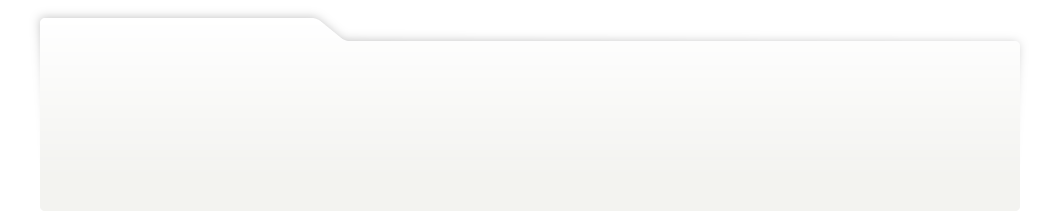
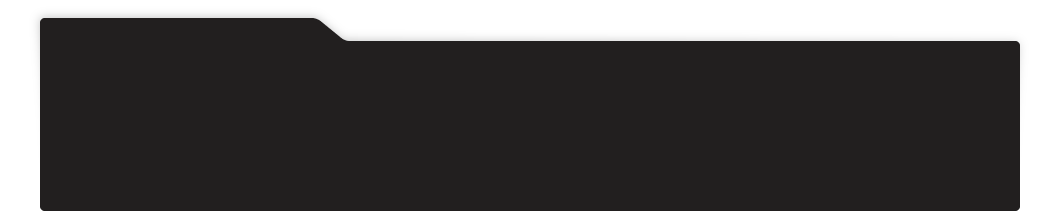
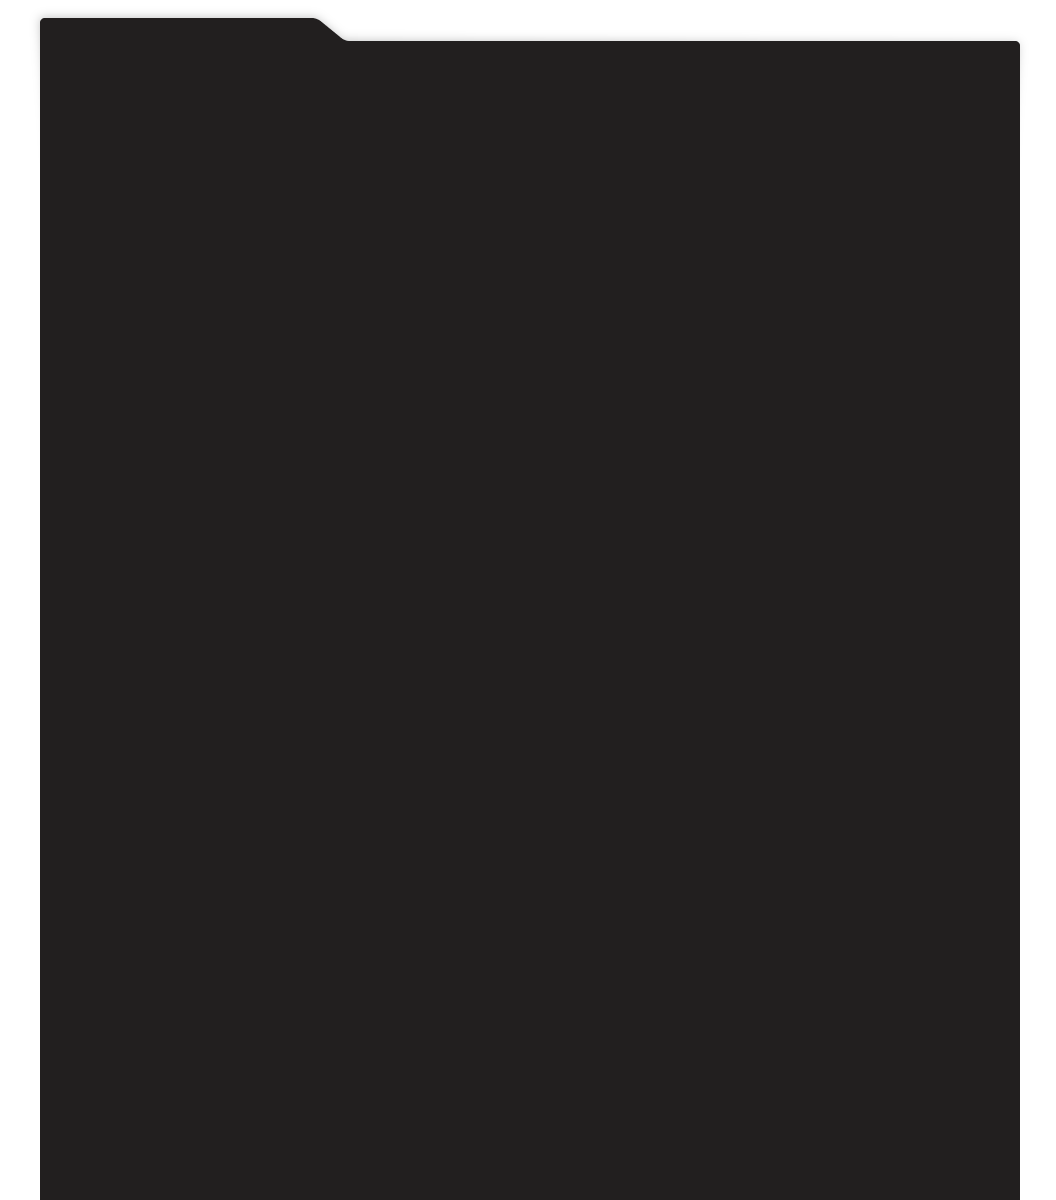
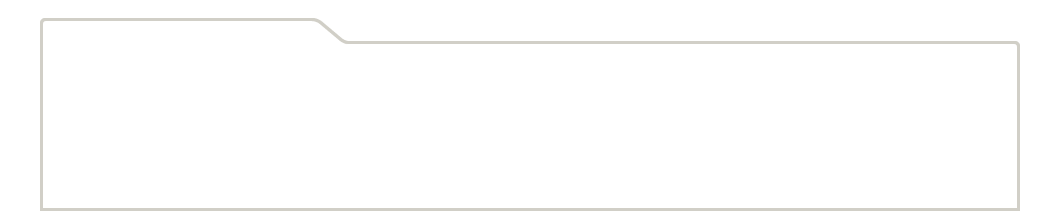
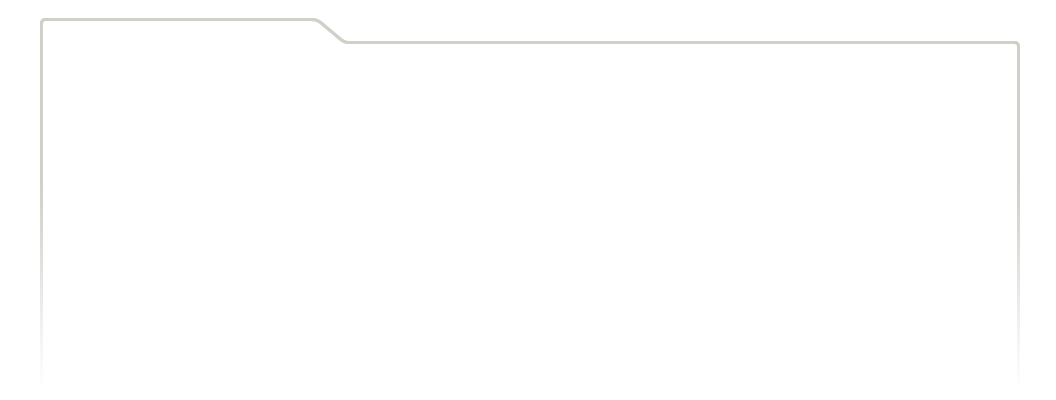
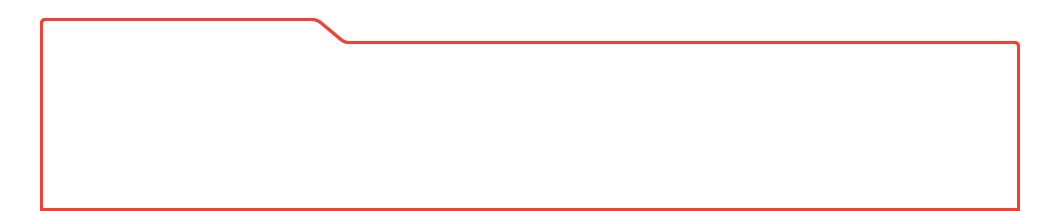
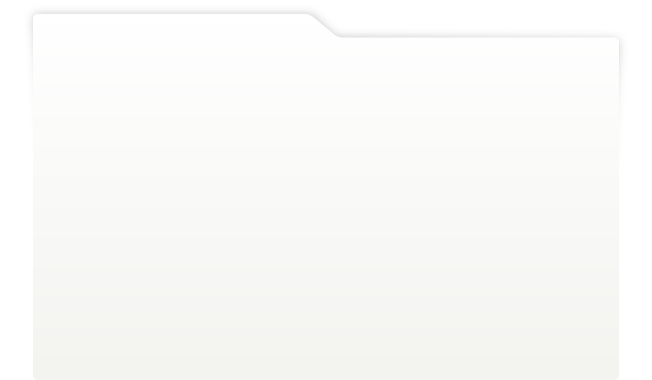
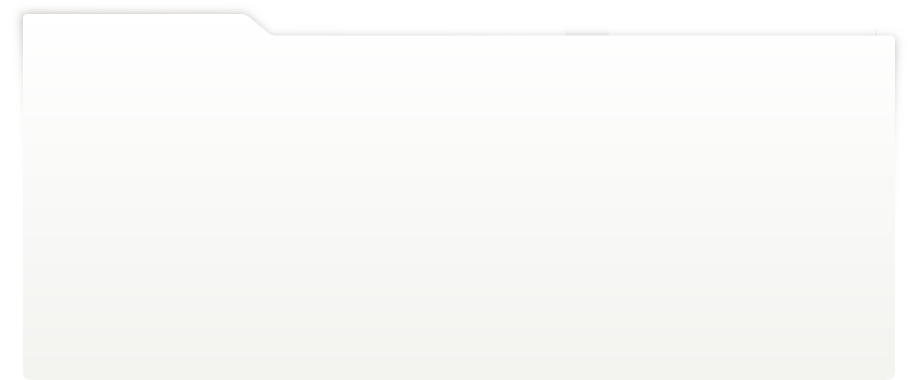
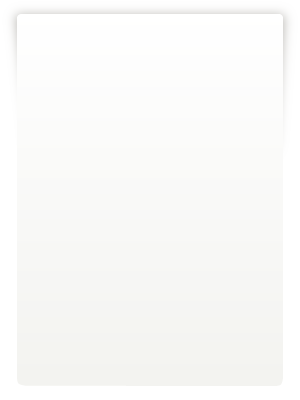
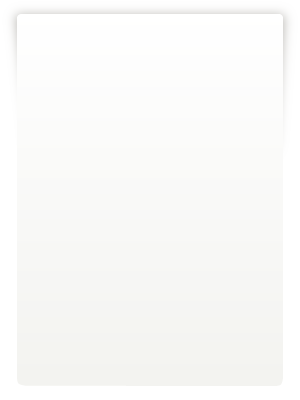
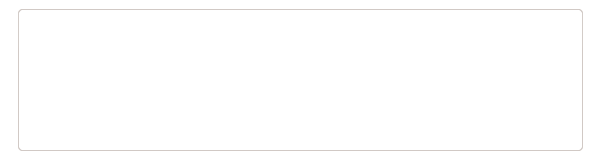
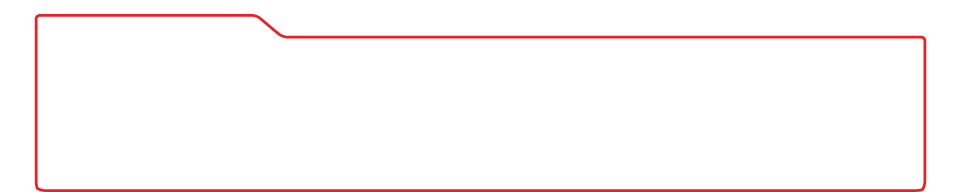
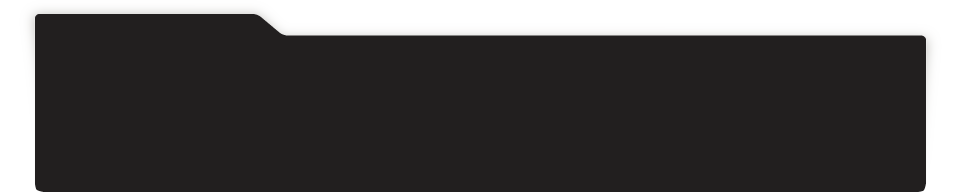
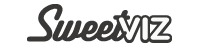
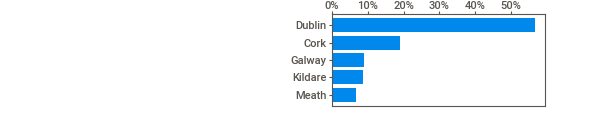
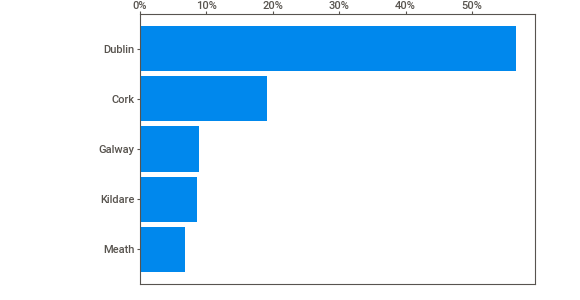
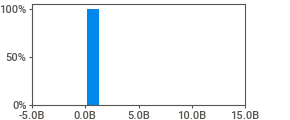
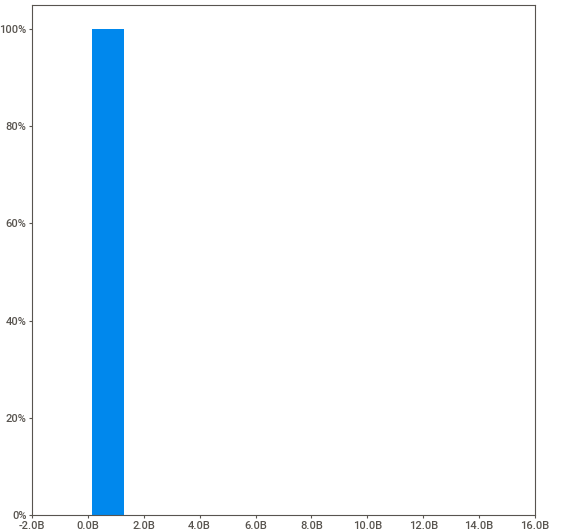
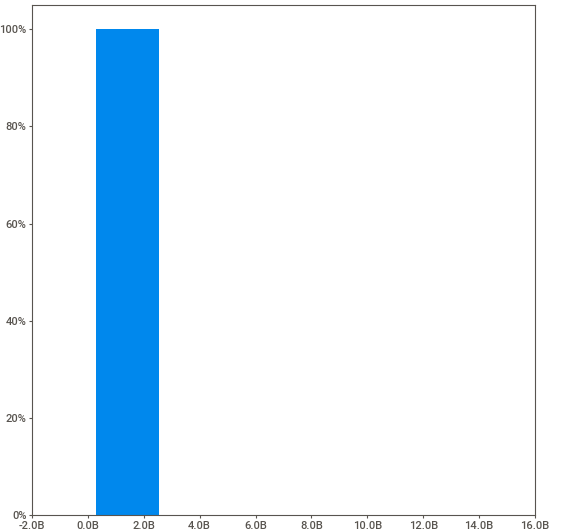
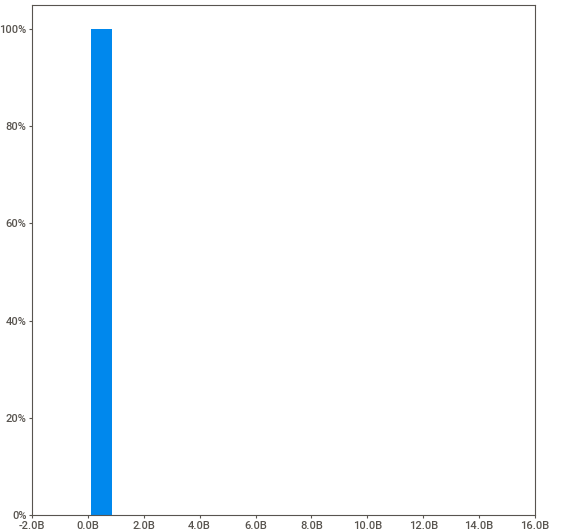
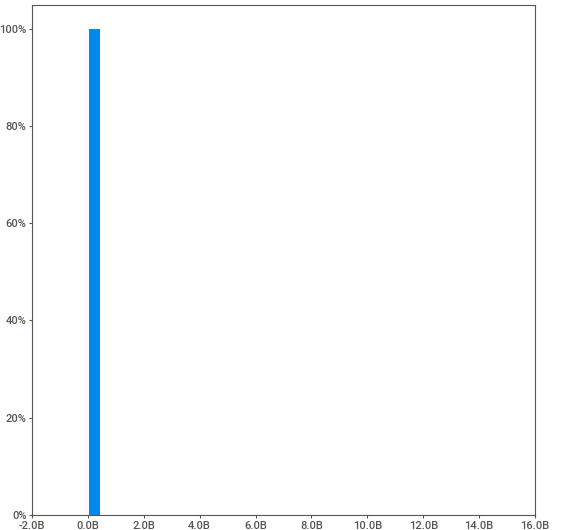
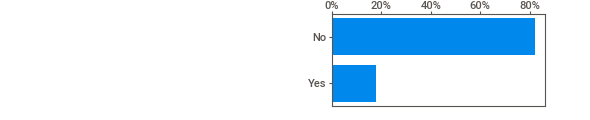
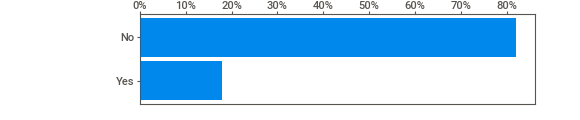
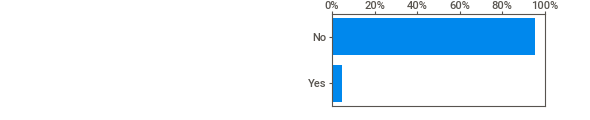
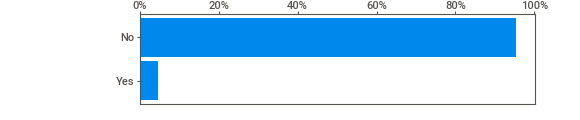
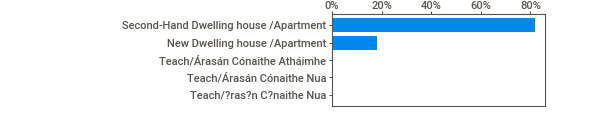
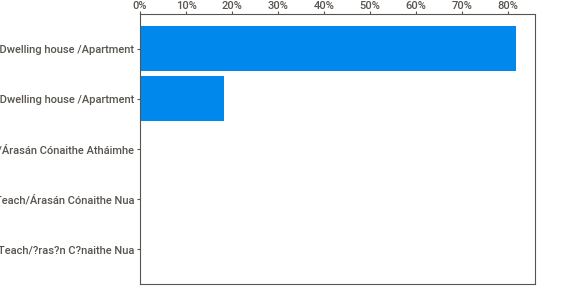
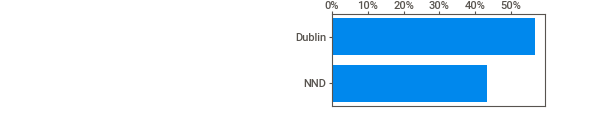
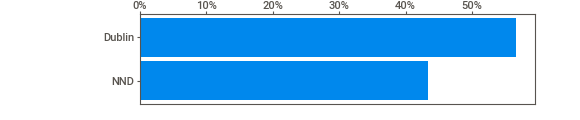
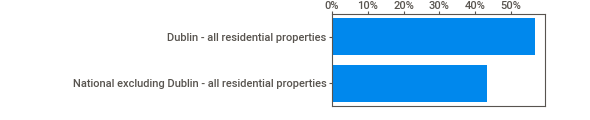
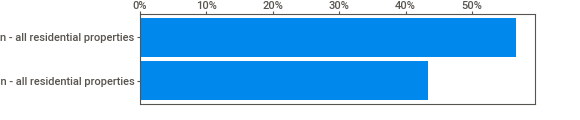
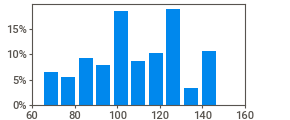
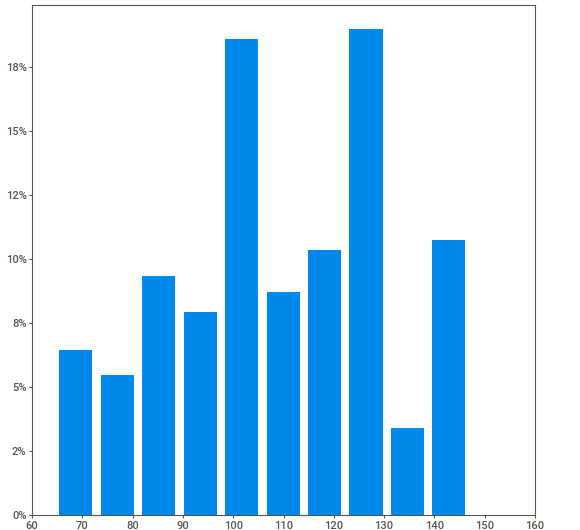
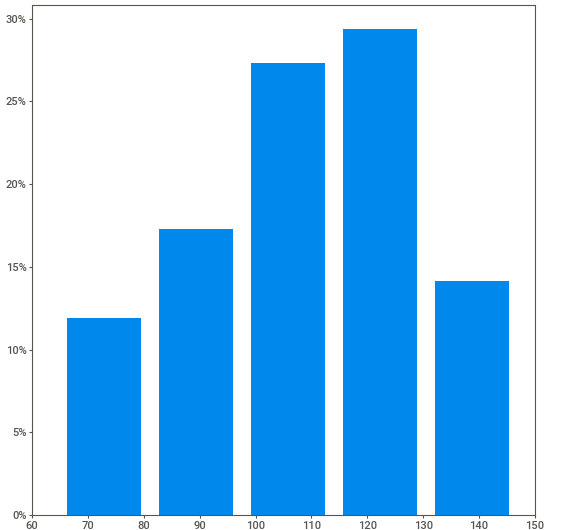
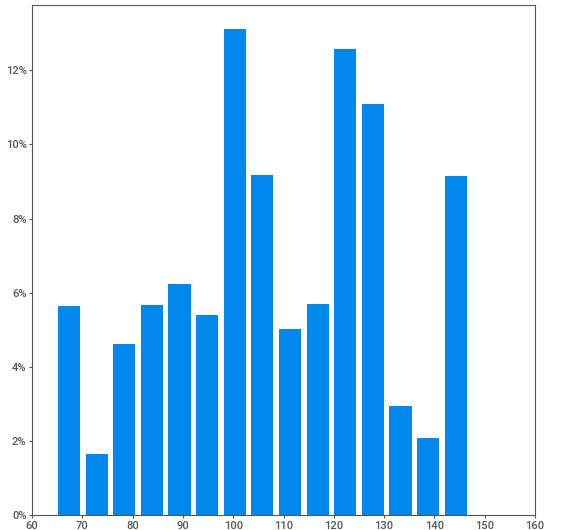
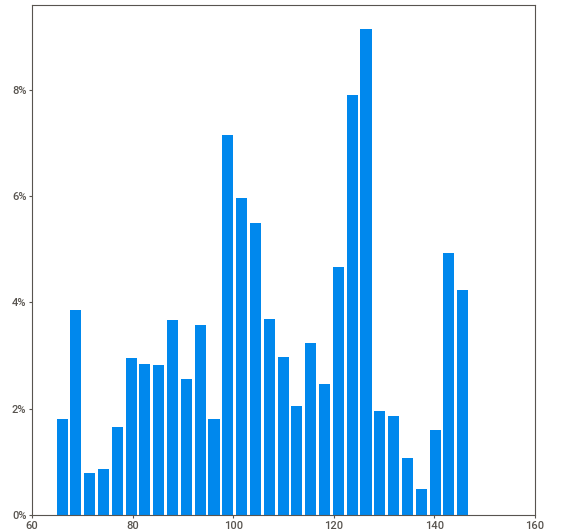
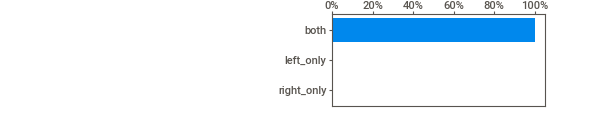
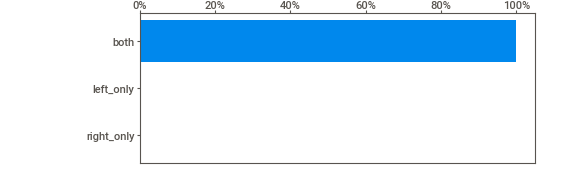
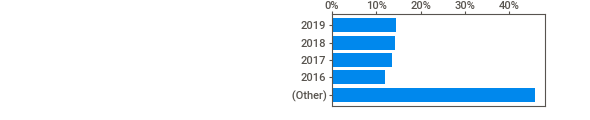
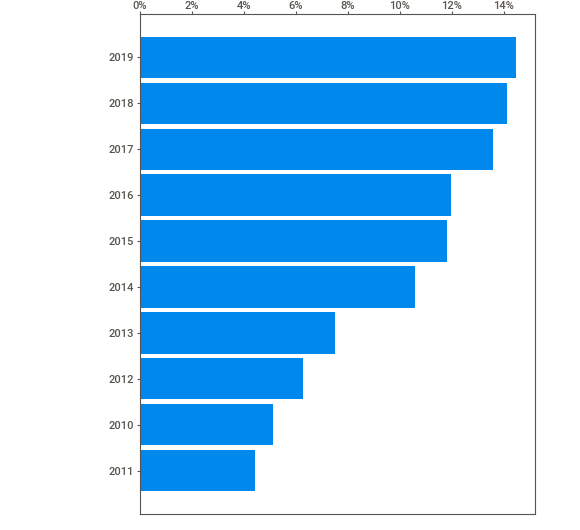
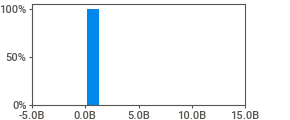
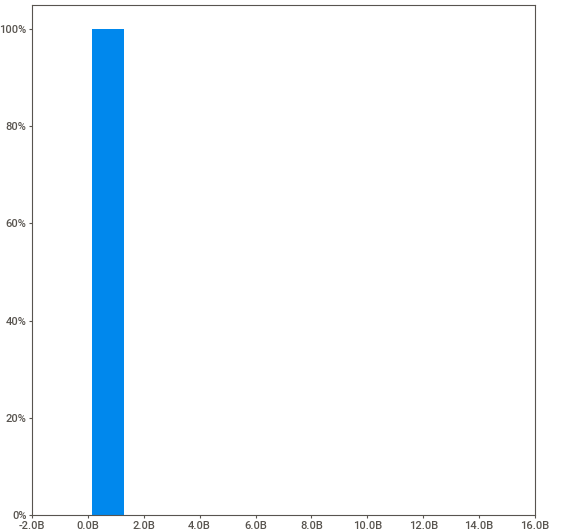
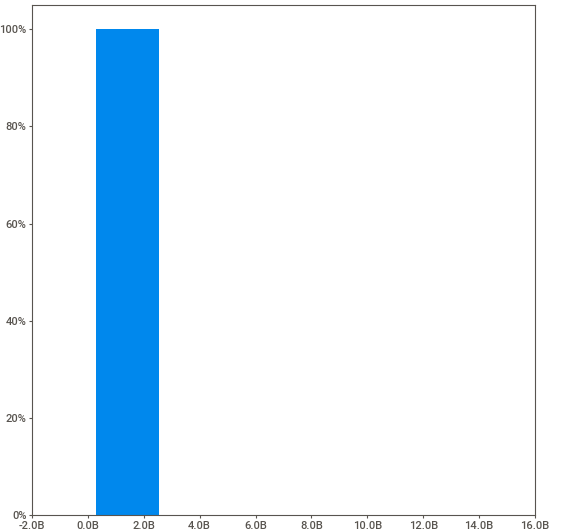
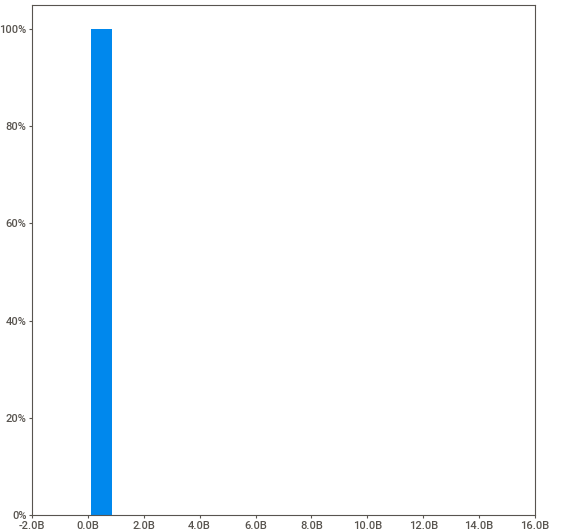
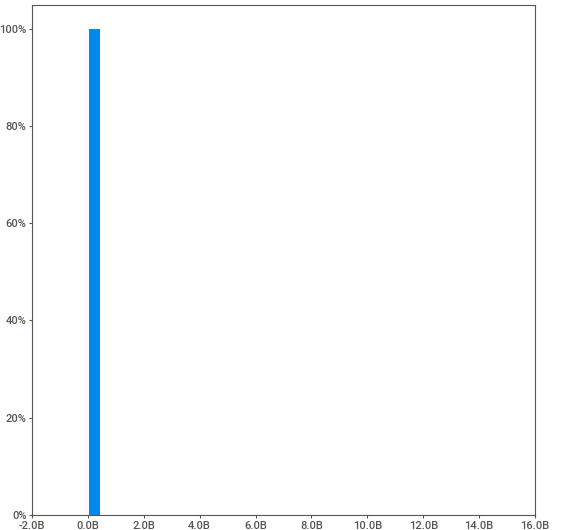
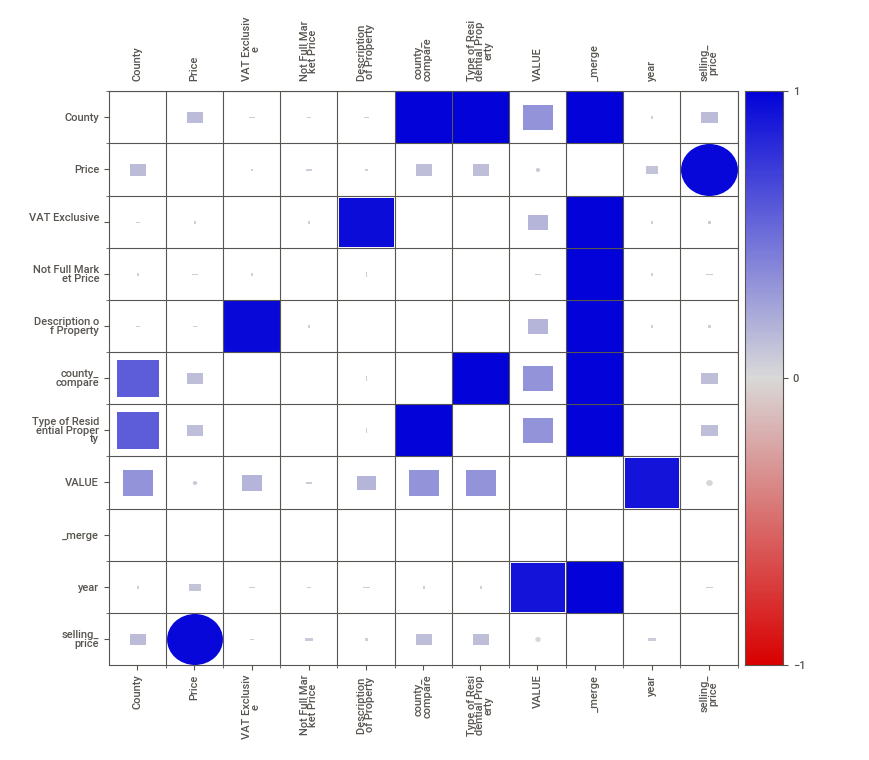
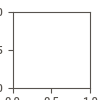


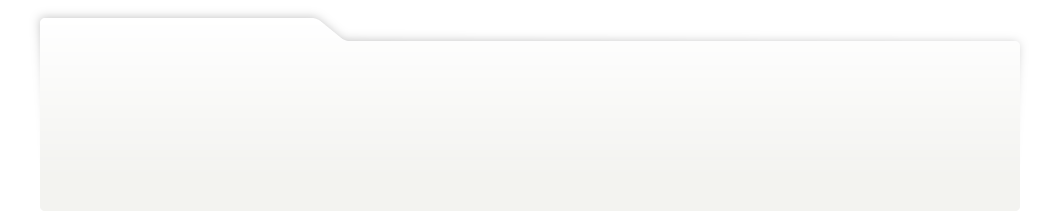
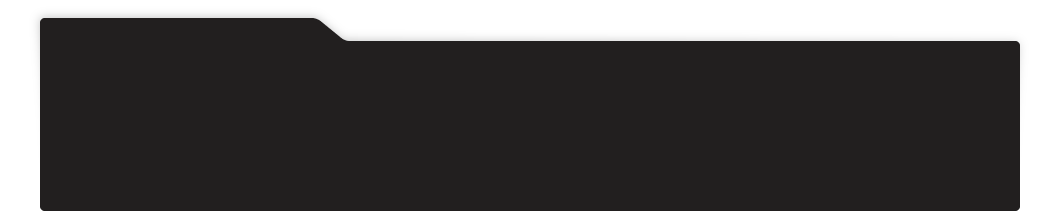
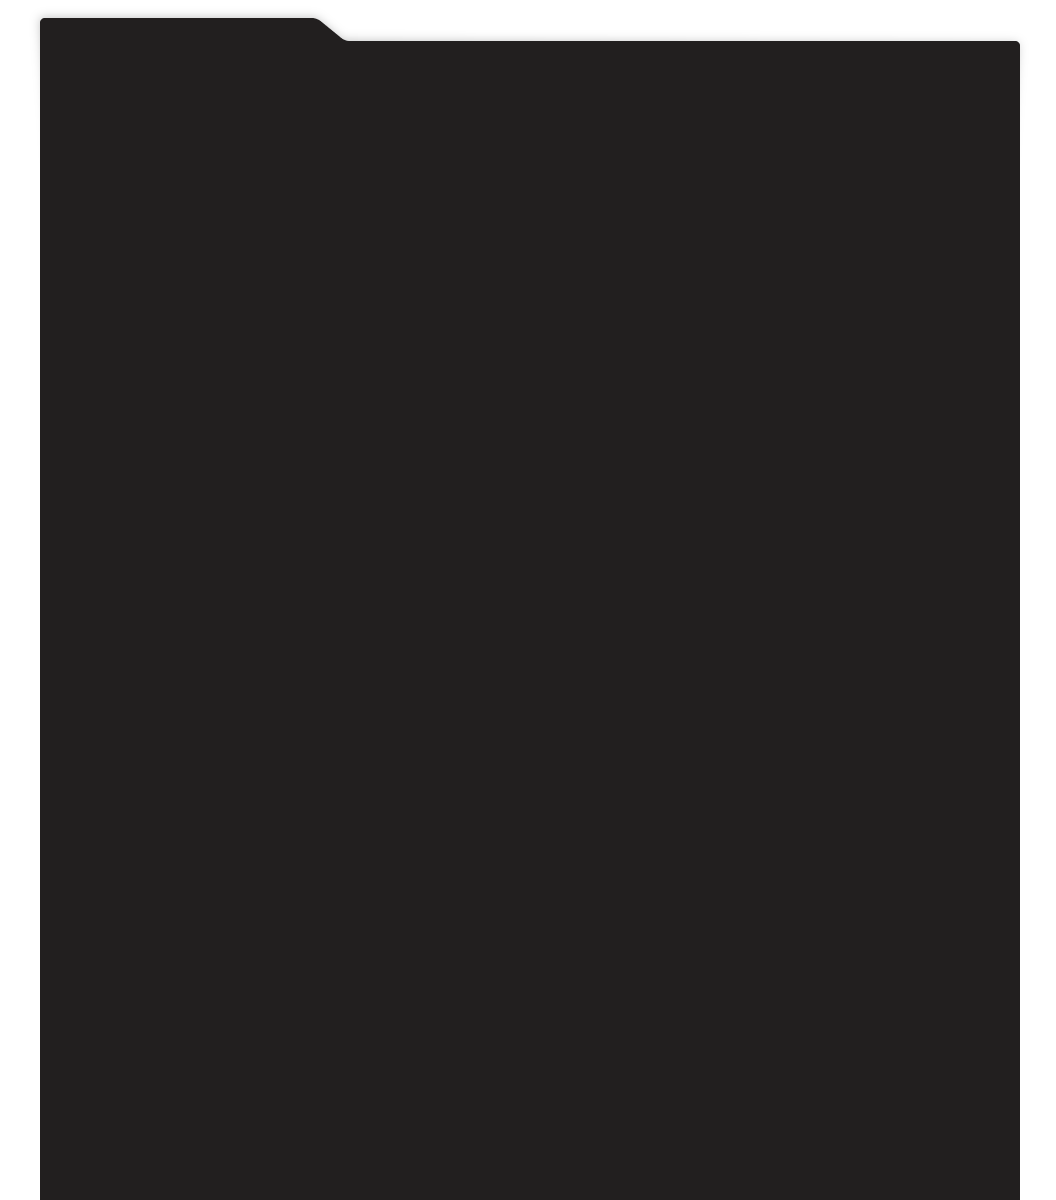
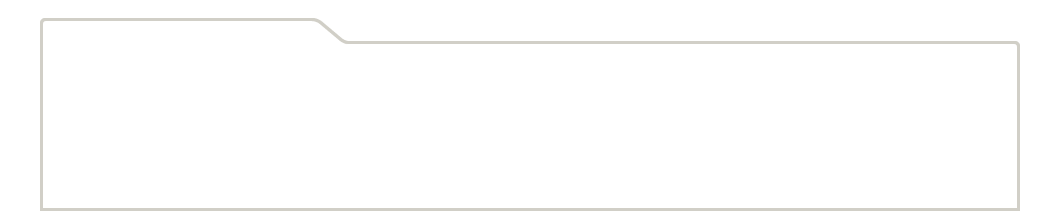
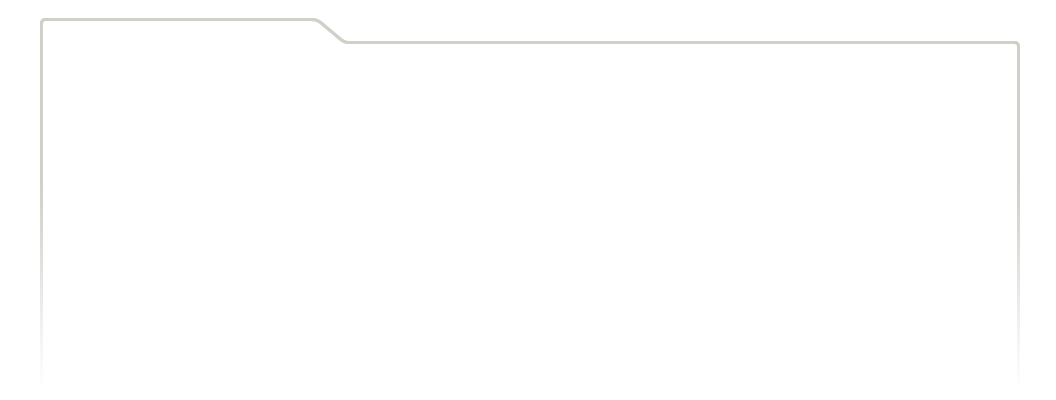
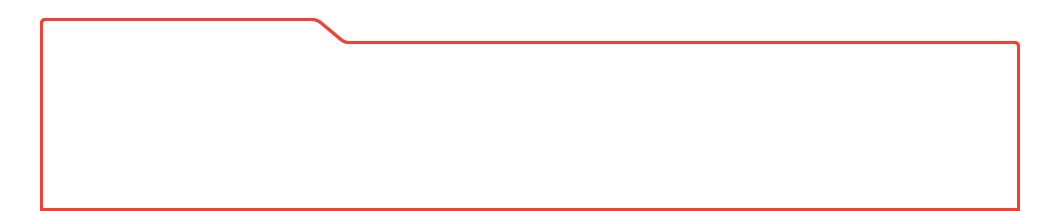
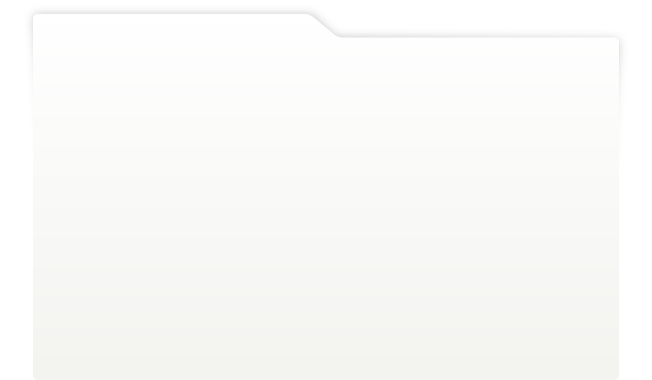
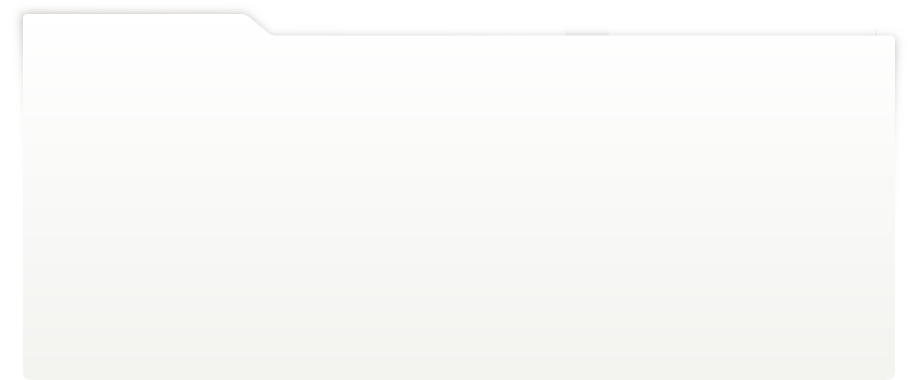
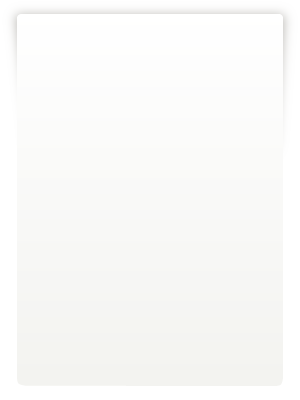
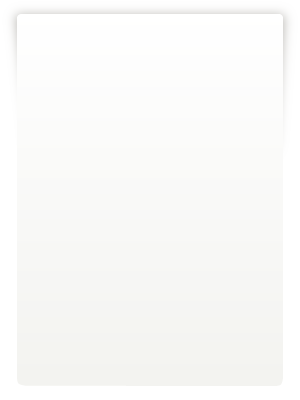
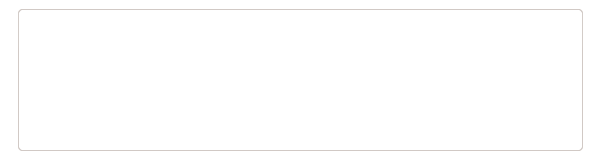
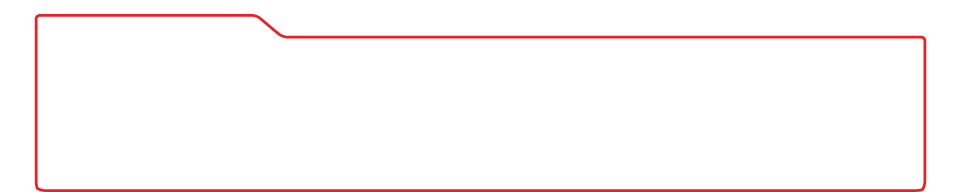
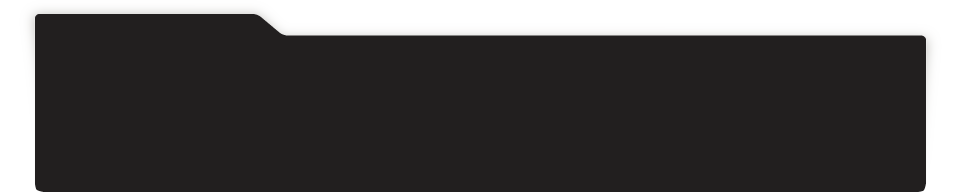
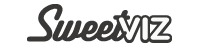
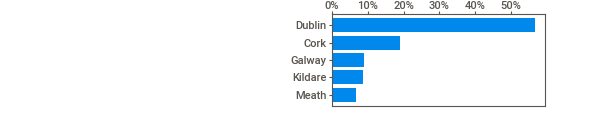
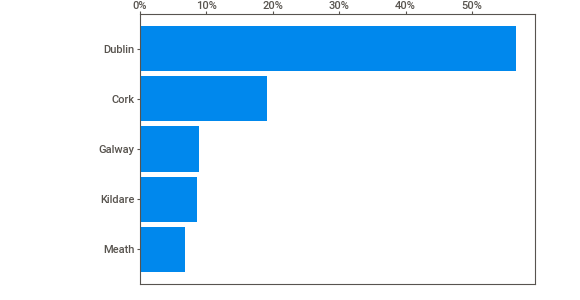
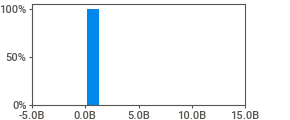
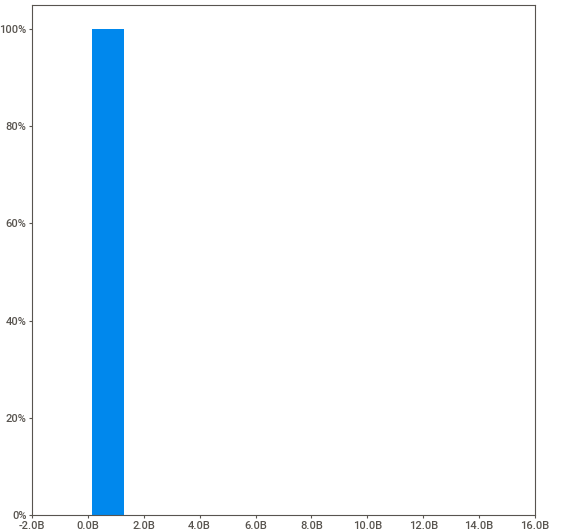
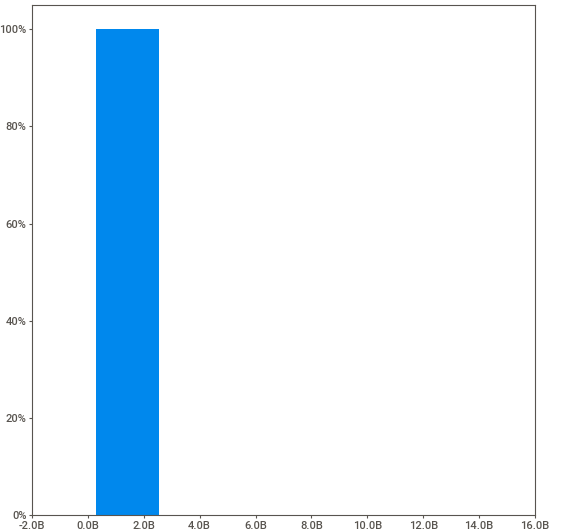
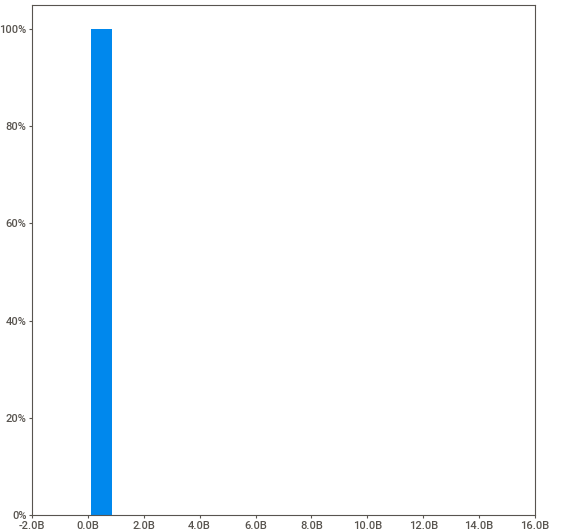
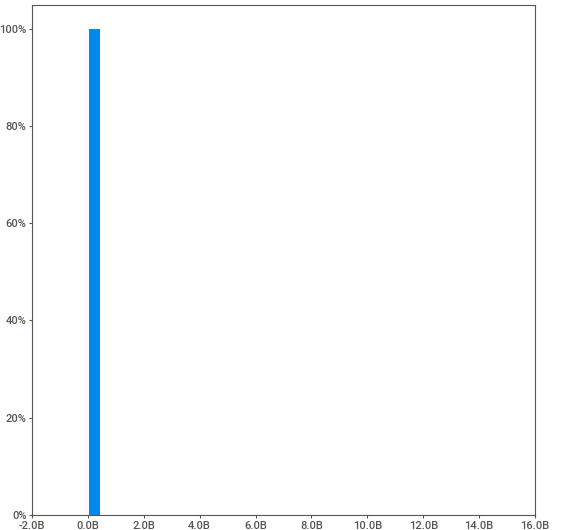
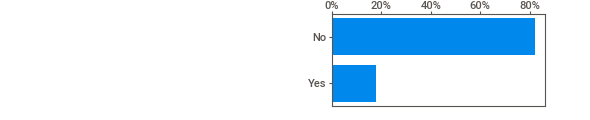
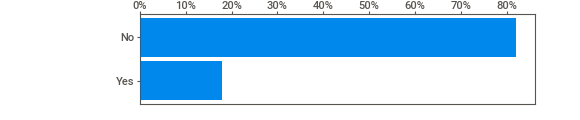
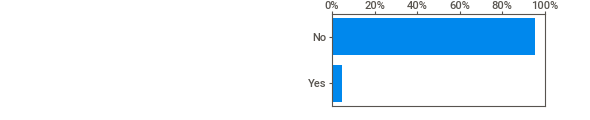
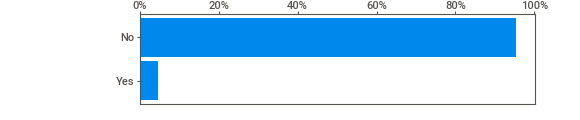
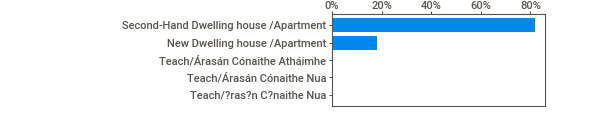
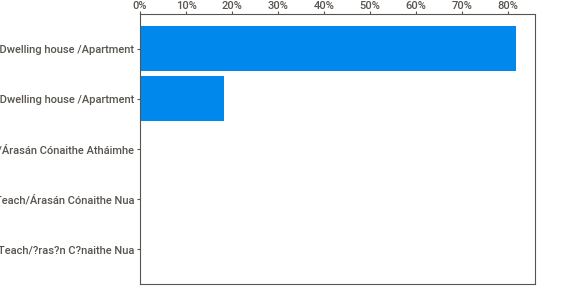
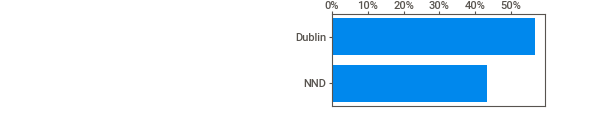
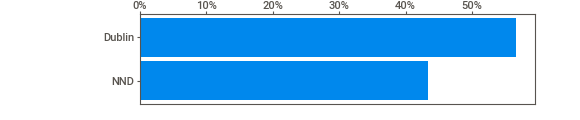
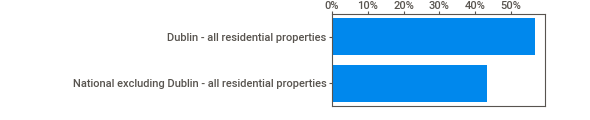
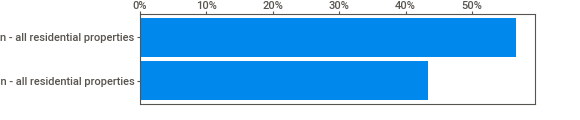
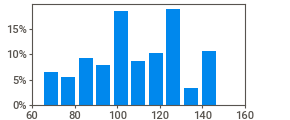
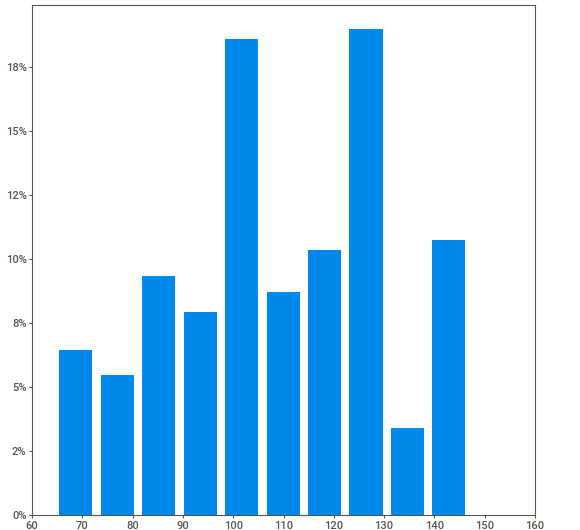
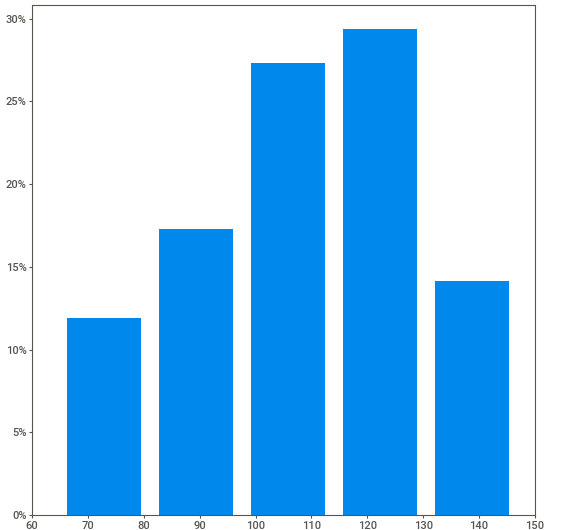
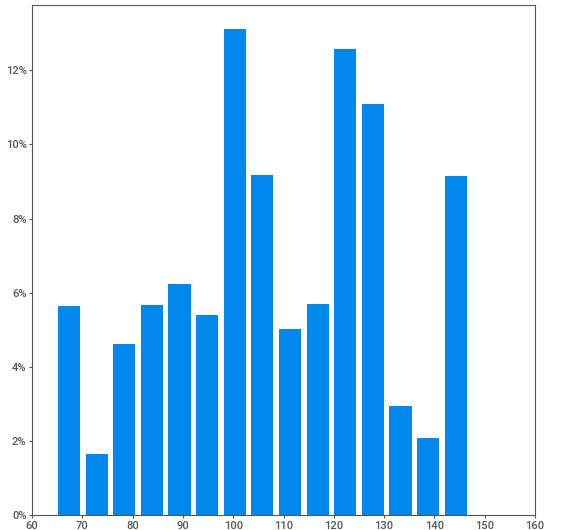
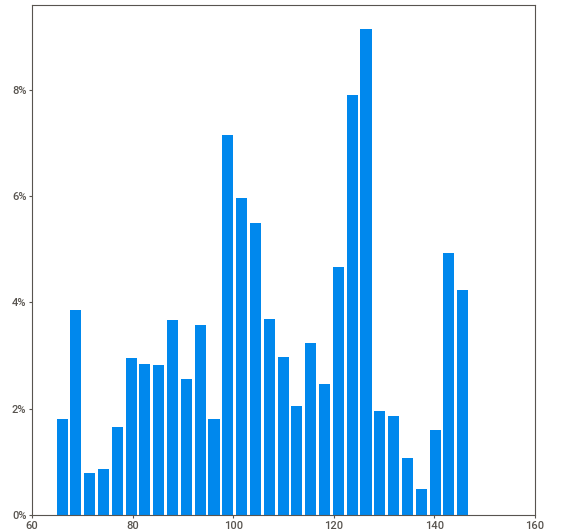
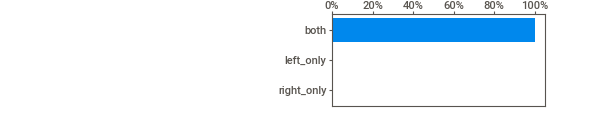
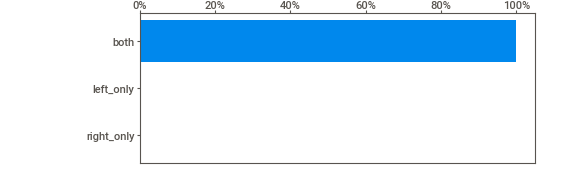
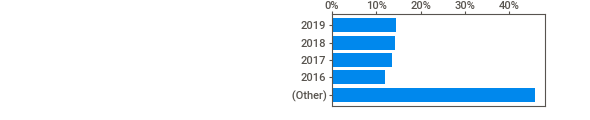
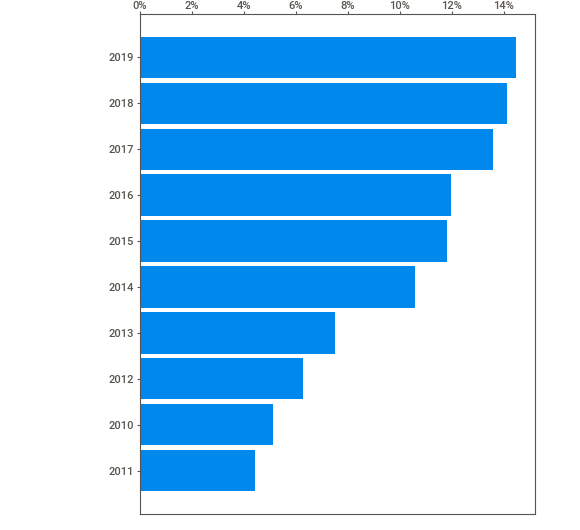
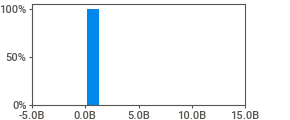
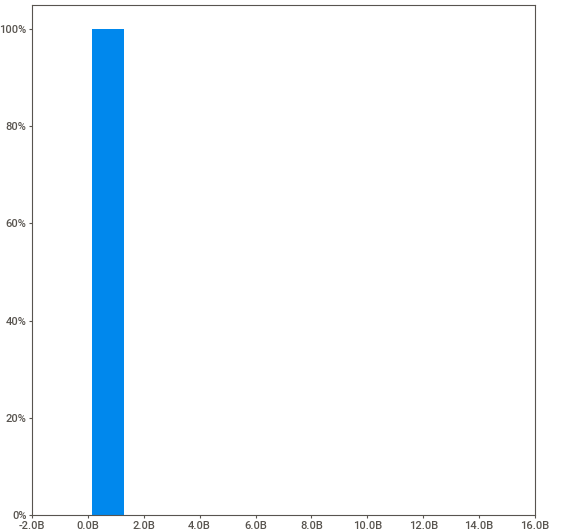
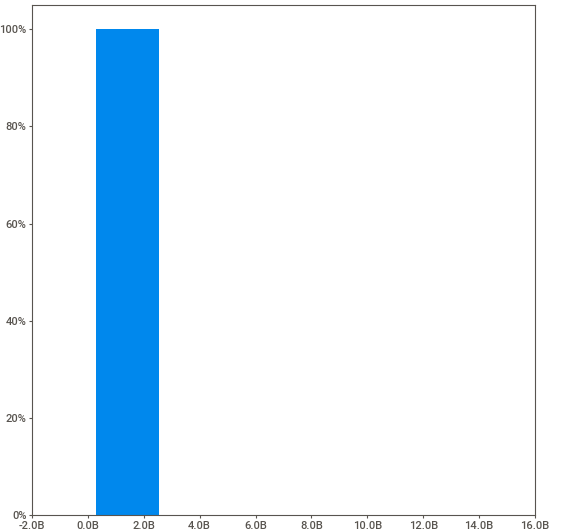
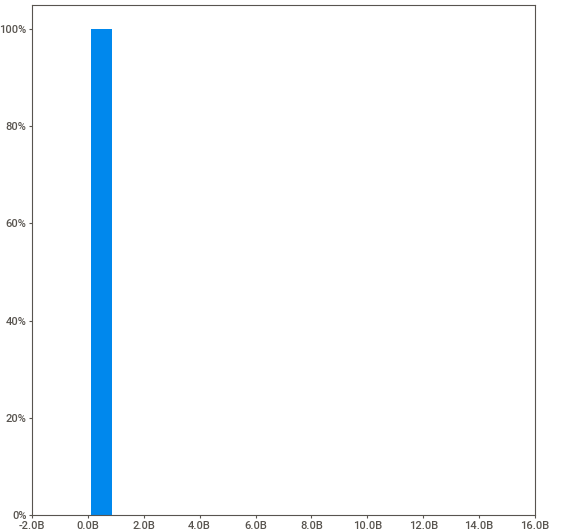
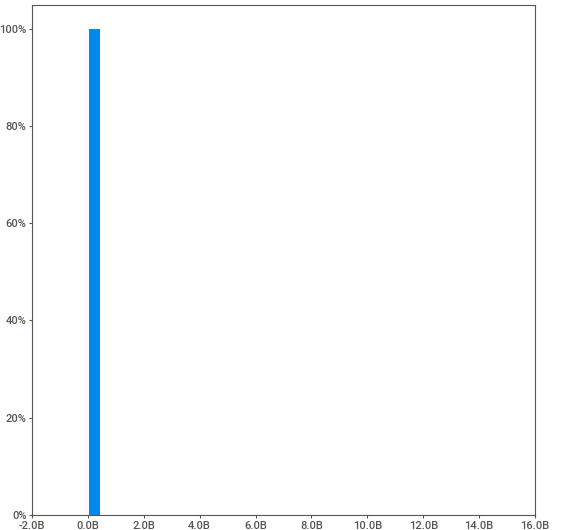
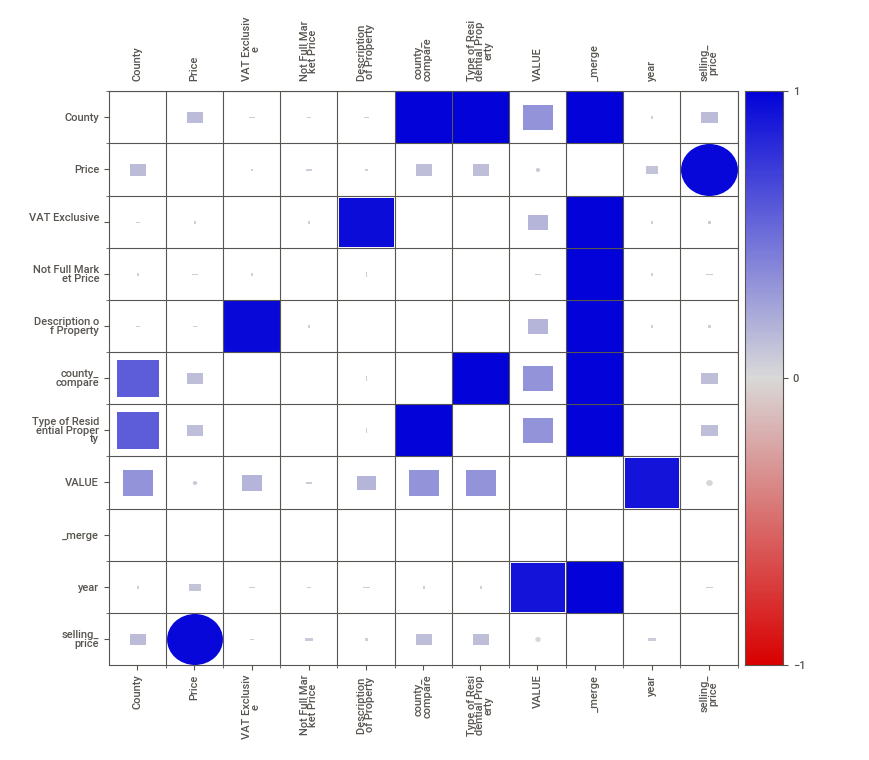
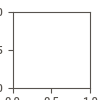

In [29]:
#display the report
advert_report.show_notebook()
advert_report.show_notebook(w=1500, h=300, scale=0.8)
#advert_report.show_html(scale=0.9)

**3. Number of properties sold per year**

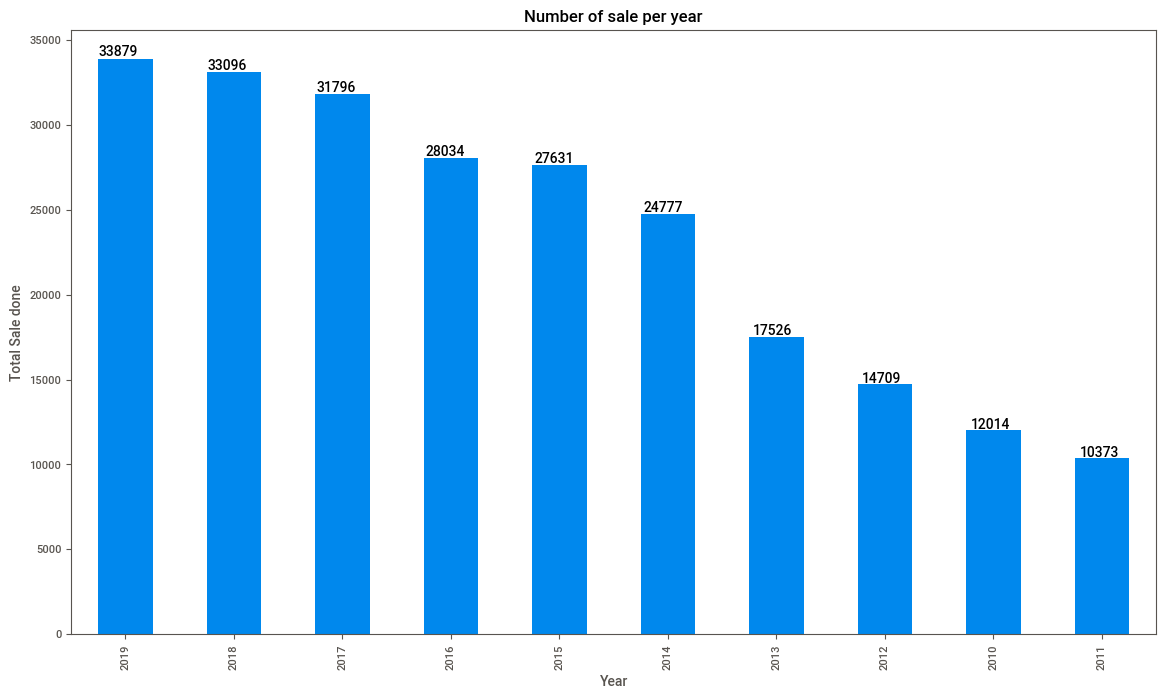

In [30]:
ax = df_merge['year'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of sale per year")
ax.set_xlabel("Year")
ax.set_ylabel("Total Sale done")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

**4. Change in Property Price over time**

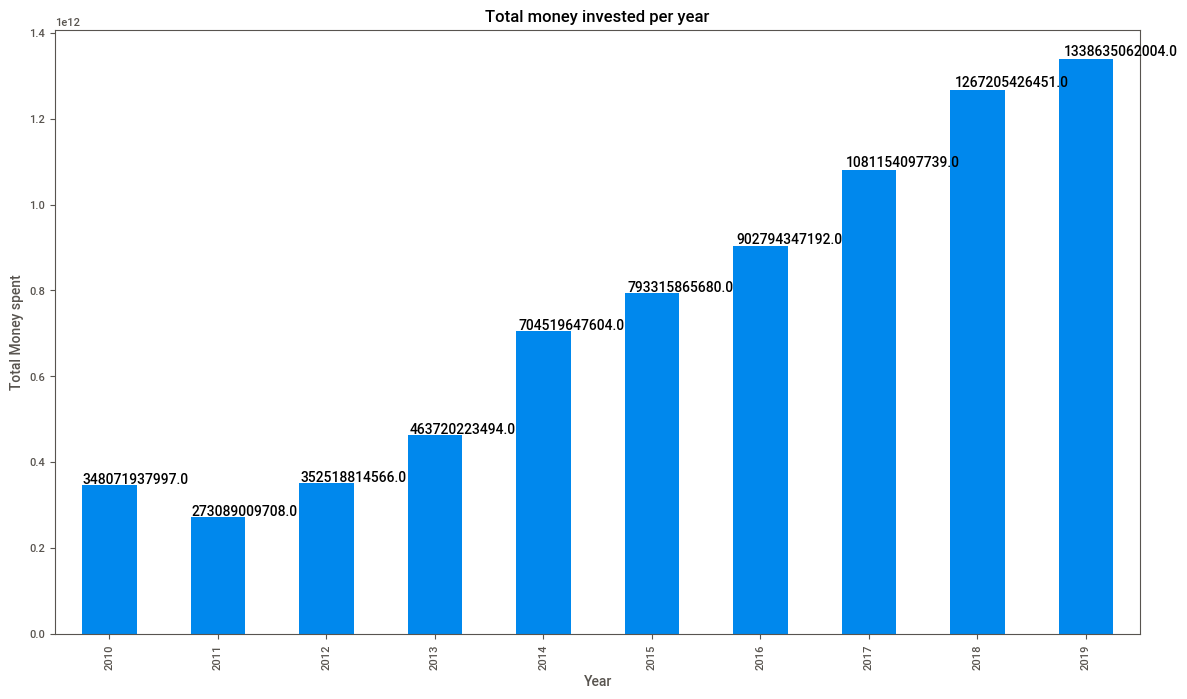

In [31]:

ax = df_merge.groupby('year').Price.sum().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Total money invested per year")
ax.set_xlabel("Year")
ax.set_ylabel("Total Money spent")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

<ipython-input-32-70c40df32db5>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ax = df_merge.groupby('year')['Price','selling_price'].sum().plot(kind='bar',


Text(0, 0.5, 'Amount in euros')

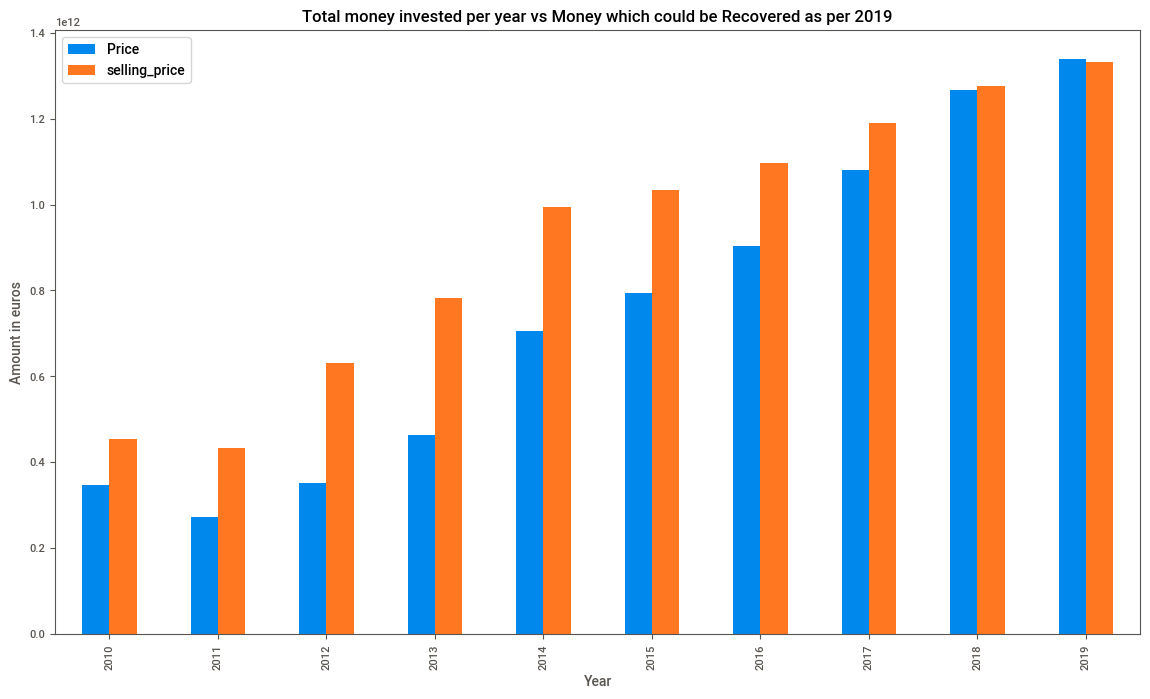

In [32]:
# Change in property price over time

# Total money spent for buying vs total money that would be recoverd in sold now

ax = df_merge.groupby('year')['Price','selling_price'].sum().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Total money invested per year vs Money which could be Recovered as per 2019")
ax.set_xlabel("Year")
ax.set_ylabel("Amount in euros")


In [33]:
# Change in Property Price per Year based on 2019 indexes

df_property_price_change = df_merge[['year','County','Price','selling_price']]
df_property_price_change['change_in_price'] = df_property_price_change['selling_price'] - df_property_price_change['Price']
print(df_property_price_change.shape)
df_property_price_change.head()

(233835, 5)


<ipython-input-33-06bb0cd1d5ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_property_price_change['change_in_price'] = df_property_price_change['selling_price'] - df_property_price_change['Price']


year  County       Price  selling_price  change_in_price
0  2010  Dublin  34300000.0   4.411530e+07     9.815297e+06
1  2010  Dublin  43850000.0   5.639813e+07     1.254813e+07
2  2010   Meath  40000000.0   4.313378e+07     3.133777e+06
3  2010  Dublin  42500000.0   5.466181e+07     1.216181e+07
4  2010    Cork  18000000.0   1.941020e+07     1.410200e+06

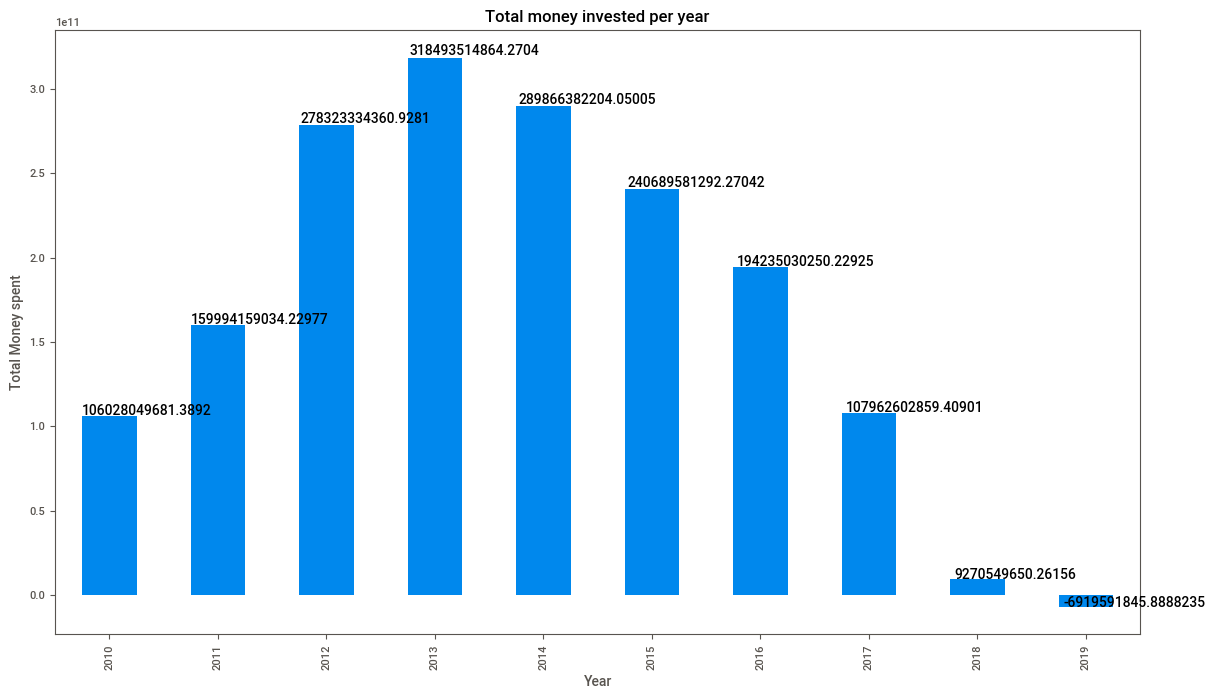

In [34]:
# Total Profit made if property bought in given year is sold in 2019

ax = df_property_price_change.groupby('year').change_in_price.sum().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Total money invested per year")
ax.set_xlabel("Year")
ax.set_ylabel("Total Money spent")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

**5. County Related information**

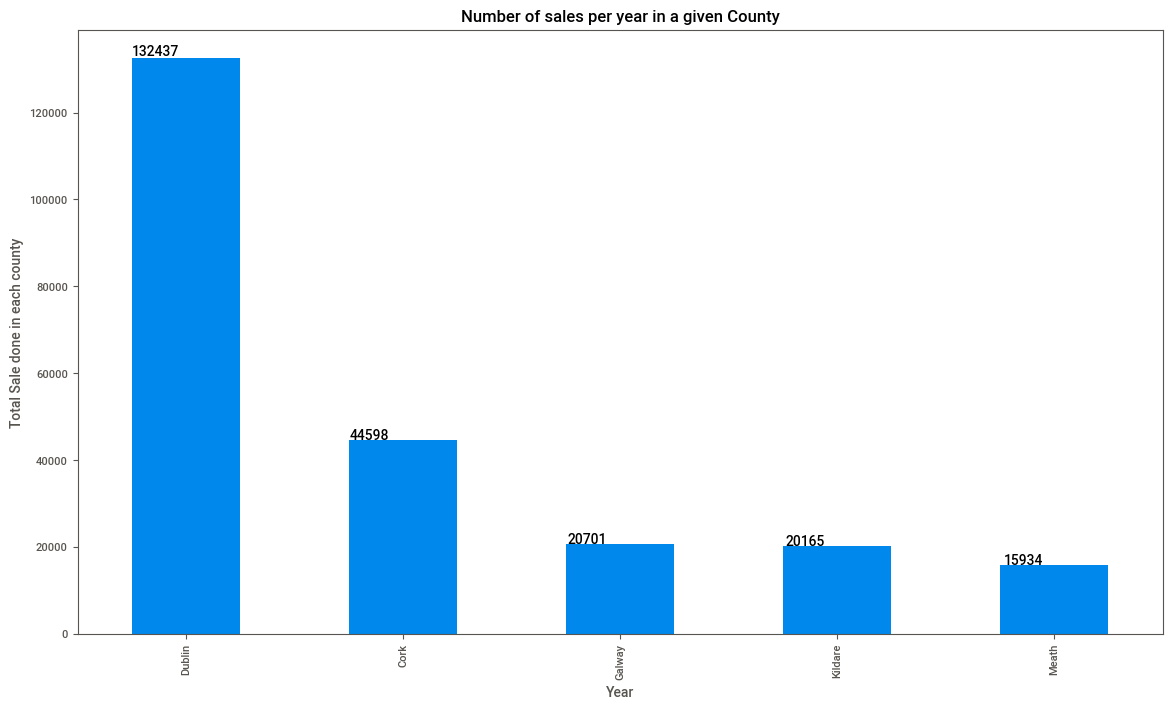

In [35]:
# total number of property sold in given county
ax = df_merge['County'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of sales per year in a given County")
ax.set_xlabel("Year")
ax.set_ylabel("Total Sale done in each county")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

<AxesSubplot:xlabel='year', ylabel='count'>

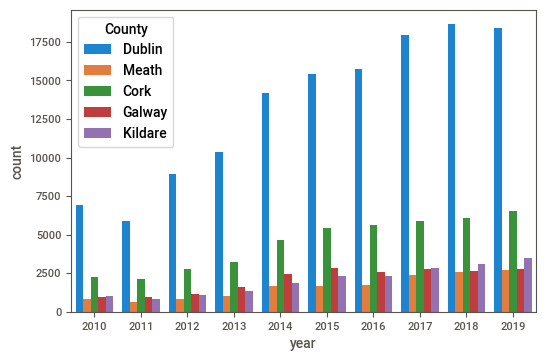

In [36]:
# Split of county related sale over year
sns.countplot(data=df_merge,x='year',hue='County')

<ipython-input-37-5a5377c0ccfc>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ax = df_merge.groupby('County')['Price','selling_price'].sum().plot(kind='bar',


Text(0, 0.5, 'Amount in euros')

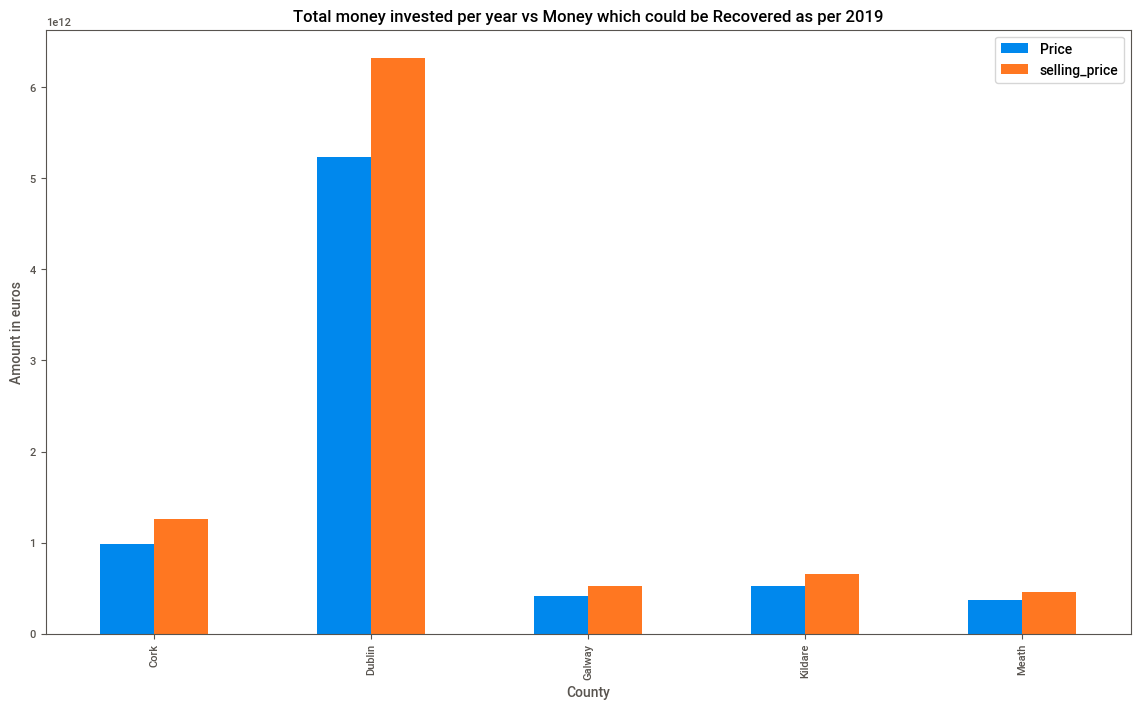

In [37]:
# Change in property price over time

# Total money spent for buying vs total money that would be recoverd in sold now

ax = df_merge.groupby('County')['Price','selling_price'].sum().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Total money invested per year vs Money which could be Recovered as per 2019")
ax.set_xlabel("County")
ax.set_ylabel("Amount in euros")

**6. Type of Residential Property**

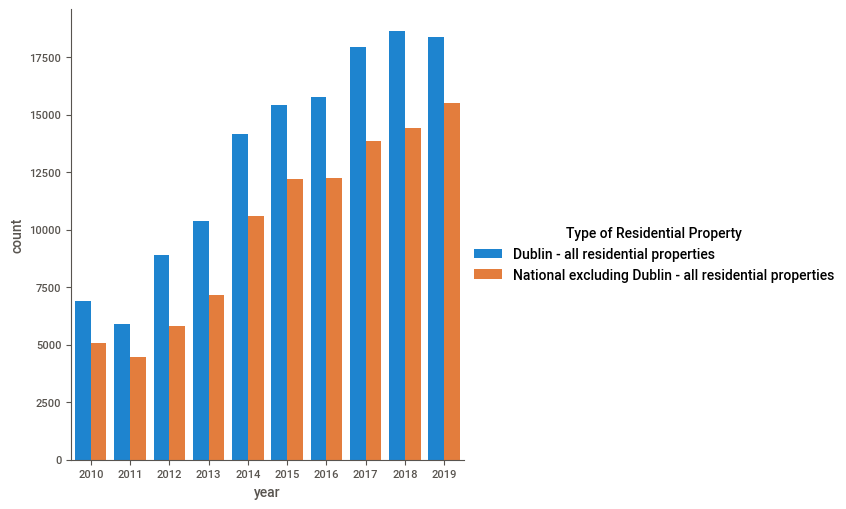

In [38]:
sns.catplot(data=df_merge,kind='count',x='year',hue='Type of Residential Property')

As we see above, type of residential property comparison, except 2011 for rest all years there has been constant growth in property development around the market. 
Dublin has seen highest growth in property, while rest of the country follows the similar trend.


**7. Price Per Index**

(233835, 4)


county_compare
Dublin    AxesSubplot(0.125,0.125;0.775x0.755)
NND       AxesSubplot(0.125,0.125;0.775x0.755)
Name: VALUE, dtype: object

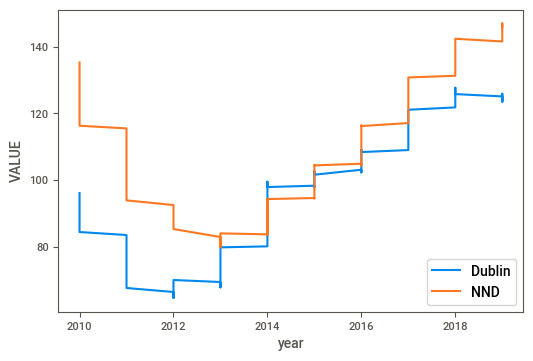

In [39]:
df_values = df_merge[['year','county_compare','County','VALUE']]
print(df_values.shape)

df_values.set_index("year", inplace=True)

df_values.groupby("county_compare")["VALUE"].plot(legend=True, xlabel="year", ylabel="VALUE")


price index values shows very interesting trends if we see above, 2010 had high property price index, but subsequently the property price dropped during 2011-2014, so people who must have bought houses during 2010 would have seen massive drop in prices (selling price).

**[Maybe cause market crash or property crash during that time]**
So, 2011 to 2013 was good time to buy a property.

However, after 2014 prices went on increasing and are on rise after that.

Same trend have been seen both in Dublin and Rest of the Ireland except Dublin(NND)




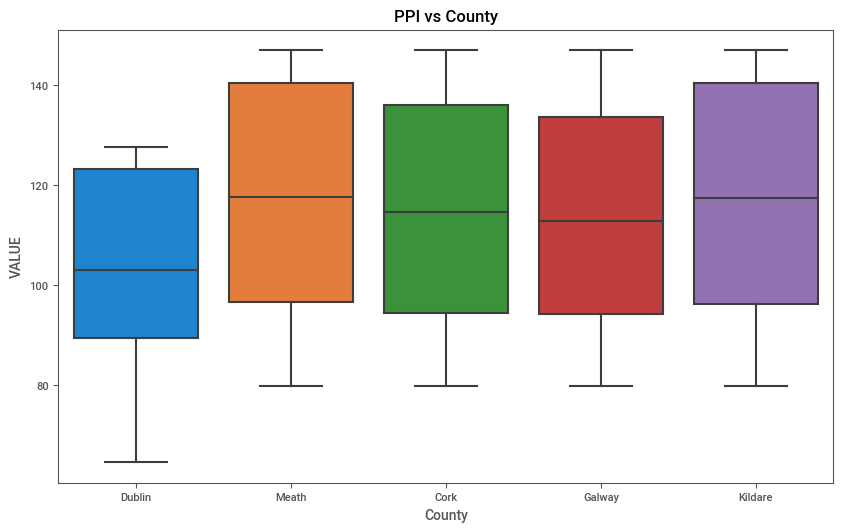

In [40]:
plt.figure(figsize=(10,6))
sns.boxplot(x='County', y='VALUE', data=df_merge)
plt.title('PPI vs County')
plt.show()

Dublin has the biggest variation in terms of property price index.
Dublin has the lowest value compared to rest counties, in terms of property value index.

But again scores highest in property price, so its very expensive but in terms of value for money is not that great.

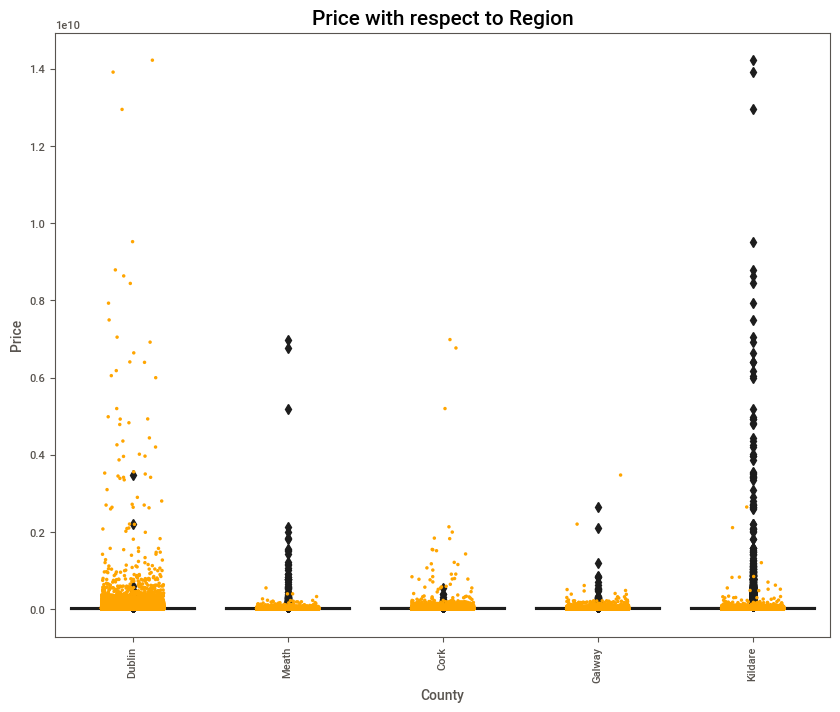

In [41]:
plt.figure(figsize=(10,8))
g=df_merge.groupby(['County'])['Price'].mean().sort_values()
g=sns.boxplot(x='County', y='Price', data=df_merge,order=list(g.index),palette='cubehelix')
g=sns.stripplot(x='County', y='Price', data=df_merge,color='orange',jitter=0.2,size=2.5)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title('Price with respect to Region',fontsize=15);

**8. Property Price in Dublin**

(132437, 14)


County
Dublin    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Price, dtype: object

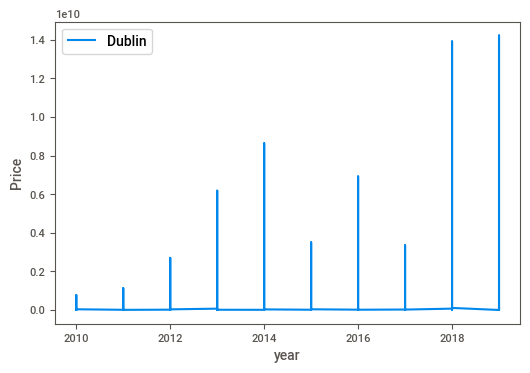

In [42]:
df_dublin = df_merge[df_merge['County'] == 'Dublin']
print(df_dublin.shape)

df_dublin.set_index("year", inplace=True)

df_dublin.groupby("County")["Price"].plot(legend=True, xlabel="year", ylabel="Price")

That is interesting observation, the prices in Dublin where not just increasing after 2014, so lets deep dive a little further to find out what is going on.


**9. How many houses were sold in Ireland over time???**

In [43]:
# Now let's see the number of houses sold in London over time
houses_sold_ireland = df_merge\
                       .groupby('Month')['Address'] \
                       .count() \
                       .reset_index() \
                       .rename(columns={'date':'Date', 'Address':'Houses Sold'})
houses_sold_ireland

Month  Houses Sold
0    2010-01          665
1    2010-02          831
2    2010-03          959
3    2010-04          979
4    2010-05          986
..       ...          ...
115  2019-08         2872
116  2019-09         2819
117  2019-10         3209
118  2019-11         3134
119  2019-12         3963

[120 rows x 2 columns]

In [44]:
# Let's plot the information above in the past two decades
fig = px.line(houses_sold_ireland[(houses_sold_ireland['Month'] >= '2010-01') & \
             (houses_sold_ireland['Month'] <= '2019-12')],
              x="Month", y="Houses Sold",
              template='seaborn', title='Sold Houses in Ireland')

fig

In [45]:
# In order to represent this events, we can plot them in the graph below
fig.add_shape( # Shape representing the decrease
    type="rect",
    xref="x",
    yref="paper",
    x0="2014-07",
    y0=0,
    x1="2015-03",
    y1=1,
    fillcolor="lightpink",
    opacity=0.5,
    layer="below",
    line_width=0,
)

fig.add_shape( # Shape representing the surge
    type="rect",
    xref="x",
    yref="paper",
    x0="2016-08",
    y0=0,
    x1="2016-09",
    y1=1,
    fillcolor="lightgreen",
    opacity=0.5,
    layer="below",
    line_width=0
)

We can also see with the plot that the average number of houses sold monthly in the second decade is higher than in the First decade. 

So let's confirm that.

In [46]:
# Getting the avg for each decade and plotting in the graph
avg_first_decade = houses_sold_ireland[(houses_sold_ireland['Month'] >= '2010-01') & \
                                      (houses_sold_ireland['Month'] <= '2015-12')]['Houses Sold'] \
                                      .mean()

avg_first_decade = round(avg_first_decade, 0)

fig.add_shape( # add a horizontal line, representing the avg in the first decade
    type="line", line_color="coral", line_width=2, opacity=1, line_dash="dot",
    x0=0, x1=1, xref="paper", y0=avg_first_decade,
    y1=avg_first_decade, yref="y"
)

fig.add_annotation( # add a text 
    text="2010-2015 average", x='2011-01', y=1500 
)

avg_second_decade = houses_sold_ireland[(houses_sold_ireland['Month'] >= '2016-01') & \
                                      (houses_sold_ireland['Month'] <= '2019-12')]['Houses Sold'] \
                                      .mean()

avg_second_decade = round(avg_second_decade, 0)

fig.add_shape( # add a horizontal line, representing the avg in the second decade
    type="line", line_color="darkcyan", line_width=2, opacity=1, line_dash="dash",
    x0=0, x1=1, xref="paper", y0=avg_second_decade,
    y1=avg_second_decade, yref="y",  
)

fig.add_annotation( # add a text 
    text="2016-2019 average", x='2011-01', y=2600 
)

From the plot above we see that the average monthly sales in the 2010-2014 half (~ 1500 sales/month) was 73.33% lower than in the second half  (~ 2600 sales/month), showing that the market recover to crisis levels after 2010.

**10. How the average house price behave in the same period? How did it behave in the other regions?**

In [47]:
# Let us have a look at unique counties that we have.
df_merge['County'].unique()

array(['Dublin', 'Meath', 'Cork', 'Galway', 'Kildare'], dtype=object)

In [48]:
# Now let us find average price in each county for given Month of sales between 2010 to 2019

df_avg_price = df_merge[['Month','County','Price']].copy()
print(df_avg_price.shape)
result_avg_price = df_avg_price.groupby(['Month','County'],as_index=False)['Price'].mean()
print(result_avg_price.shape)
result_avg_price.head()


(233835, 3)
(600, 3)


Month   County         Price
0  2010-01     Cork  2.533842e+07
1  2010-01   Dublin  3.517853e+07
2  2010-01   Galway  2.861110e+07
3  2010-01  Kildare  2.735030e+07
4  2010-01    Meath  2.181413e+07

In [49]:
# Let's plot the information above in the past two decades
px.line(result_avg_price,
        x="Month", y="Price", color="County",
        template='seaborn', title='Average House Price in Ireland by Region')

From observing the plot, we see that Dublin had a higher average price in the past decade, followed by the county kildare region. We can say that it seems that the regions had a similar trend regarding house prices in the period. The most visible exception is Dublin, that appears to have had a higher growth rate compared to the other regions in the period from January/2010 to December/2019

##### 4. Outlier Detection

Using an unsupervised approach, implement a method to classify whether a property sale should be considered an outlier or not. In the context of the county and type of property, the Revenue is interested in 2 types of outliers:

* **Residential sales which may have been sold for abnormally low values** i.e. those which may have been sold for less than what they are worth.


The Revenue are interested in creating a backlog of property sales to investigate for tax avoidance.

* **Residential sales which may have been sold for abnormally high values** i.e. those sales which may have been entered in error, such as apartment blocks.

The Revenue are interested in identifying sales which do not represent a sale of a single residential property. The client believes there may be many instances of a single sale which are for several properties, such as apartment blocks. 


Therefore, a deliverable for the client is to provide a list of properties which were sold for abnormally low and high values i.e. outliers. 

The approach chosen should be informed from information you have observed in the previous step.


**Definition:** Outliers are observations in dataset that are not like rest other data points  ie they dont fit in.

Most common types are one that are far away from rest obervations.

When we have one or 2-dimensional dataset it is very easy to find such by visualizing them and pin pointing them. However, it becomes very challenging when we have many input points on a high dimensional input space.

In this case, simple statistical methods for identifying outliers can break down, such as methods that use standard deviations or the interquartile range or z-score.

So we need unsupervised machine learning models to identify such outlier cases.

**ALGOS:**
There are multiple algorithm which could help us solve the problem above like Isolation Forest, DBSCAN, Minimum Covariance Determinant etc...




**ONE-CLASS SVM:**

So I will be using the ONE-CLASS SVM algorithm for our task, the SVM algorithm developed for classification problem can be used for outlier detection too using its one-class classification modification.

Working of this technique is based on capturing the density of majority class and identifies cases of high density as majority class, which also means it will be classifying example of less density as outliers.


Although SVM is a classification algorithm and One-Class SVM is also a classification algorithm, it can be used to discover outliers in input data for both regression and classification datasets.


The class provides the “nu” argument that specifies the approximate ratio of outliers in the dataset, which defaults to 0.1. In this case, we will set it to 0.01, found with model optimization tuning.
[Grid Search, Random Search, Bayesian Optimization]


Alright back to coding.....



**Data Encoding**

I need to get my dataset into format that my ML model can understand, this involves encoding categorical variables into numerical format.

Now I will be using ***one-hot encoding instead of label encoder***, cause label encoder will assign value of 0,1,2,3 to categories and in calculation model may give more importance to value 3 then one with 1 and that is fine for ordinal cases but not in our cases where say  every county should get equal importance.


**Dataset one-hot encoding for categorical features**


In [50]:
# Printing a glimpse of actual dataset
df_merge.head(5)

date_of_sale                                 Address  County       Price  \
0   2010-01-01  5 Braemor Drive, Churchtown, Co.Dublin  Dublin  34300000.0   
1   2010-01-04     1 Meadow Avenue, Dundrum, Dublin 14  Dublin  43850000.0   
2   2010-01-04                 1 The Haven, Mornington   Meath  40000000.0   
3   2010-01-04          12 Sallymount Avenue, Ranelagh  Dublin  42500000.0   
4   2010-01-04   15 Carriglawn, Waterpark, Carrigaline    Cork  18000000.0   

  VAT Exclusive Not Full Market Price                Description of Property  \
0            No                    No  Second-Hand Dwelling house /Apartment   
1            No                    No  Second-Hand Dwelling house /Apartment   
2            No                    No  Second-Hand Dwelling house /Apartment   
3            No                    No  Second-Hand Dwelling house /Apartment   
4            No                    No  Second-Hand Dwelling house /Apartment   

     Month county_compare                       Type of Residential Property  \
0  2010-01         Dublin                Dublin - all residential properties   
1  2010-01         Dublin                Dublin - all residential properties   
2  2010-01            NND  National excluding Dublin - all residential pr...   
3  2010-01         Dublin                Dublin - all residential properties   
4  2010-01            NND  National excluding Dublin - all residential pr...   

   VALUE _merge  year  selling_price  
0   96.1   both  2010   4.411530e+07  
1   96.1   both  2010   5.639813e+07  
2  135.3   both  2010   4.313378e+07  
3   96.1   both  2010   5.466181e+07  
4  135.3   both  2010   1.941020e+07

In [51]:
# selecting categorical columns

df_encode = df_merge[['County','VAT Exclusive','Not Full Market Price','Description of Property','Type of Residential Property','year']]
print(df_encode.shape)
df_encode.head()

(233835, 6)


County VAT Exclusive Not Full Market Price  \
0  Dublin            No                    No   
1  Dublin            No                    No   
2   Meath            No                    No   
3  Dublin            No                    No   
4    Cork            No                    No   

                 Description of Property  \
0  Second-Hand Dwelling house /Apartment   
1  Second-Hand Dwelling house /Apartment   
2  Second-Hand Dwelling house /Apartment   
3  Second-Hand Dwelling house /Apartment   
4  Second-Hand Dwelling house /Apartment   

                        Type of Residential Property  year  
0                Dublin - all residential properties  2010  
1                Dublin - all residential properties  2010  
2  National excluding Dublin - all residential pr...  2010  
3                Dublin - all residential properties  2010  
4  National excluding Dublin - all residential pr...  2010

In [52]:
# Converting categorical columns to one-hot encoded version
df_encode2 = pd.get_dummies(df_encode,drop_first=True)
print(df_encode2.shape)
df_encode2.head()

(233835, 12)


year  County_Dublin  County_Galway  County_Kildare  County_Meath  \
0  2010              1              0               0             0   
1  2010              1              0               0             0   
2  2010              0              0               0             1   
3  2010              1              0               0             0   
4  2010              0              0               0             0   

   VAT Exclusive_Yes  Not Full Market Price_Yes  \
0                  0                          0   
1                  0                          0   
2                  0                          0   
3                  0                          0   
4                  0                          0   

   Description of Property_Second-Hand Dwelling house /Apartment  \
0                                                  1               
1                                                  1               
2                                                  1               
3                                                  1               
4                                                  1               

   Description of Property_Teach/?ras?n C?naithe Nua  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   Description of Property_Teach/Árasán Cónaithe Atháimhe  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   Description of Property_Teach/Árasán Cónaithe Nua  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   Type of Residential Property_National excluding Dublin - all residential properties  
0                                                  0                                    
1                                                  0                                    
2                                                  1                                    
3                                                  0                                    
4                                                  1

In [53]:
# Selecting columns with values that dont need encoding

df_non_encode = df_merge[['VALUE','Price','selling_price']]
print(df_non_encode.shape)
df_non_encode.head()

(233835, 3)


VALUE       Price  selling_price
0   96.1  34300000.0   4.411530e+07
1   96.1  43850000.0   5.639813e+07
2  135.3  40000000.0   4.313378e+07
3   96.1  42500000.0   5.466181e+07
4  135.3  18000000.0   1.941020e+07

In [54]:
# joining the two dataframes to create final copy for processing

concatenated_data = pd.concat([df_encode2, df_non_encode], axis=1)
print(concatenated_data.shape)
concatenated_data.head()

(233835, 15)


year  County_Dublin  County_Galway  County_Kildare  County_Meath  \
0  2010              1              0               0             0   
1  2010              1              0               0             0   
2  2010              0              0               0             1   
3  2010              1              0               0             0   
4  2010              0              0               0             0   

   VAT Exclusive_Yes  Not Full Market Price_Yes  \
0                  0                          0   
1                  0                          0   
2                  0                          0   
3                  0                          0   
4                  0                          0   

   Description of Property_Second-Hand Dwelling house /Apartment  \
0                                                  1               
1                                                  1               
2                                                  1               
3                                                  1               
4                                                  1               

   Description of Property_Teach/?ras?n C?naithe Nua  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   Description of Property_Teach/Árasán Cónaithe Atháimhe  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   Description of Property_Teach/Árasán Cónaithe Nua  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   Type of Residential Property_National excluding Dublin - all residential properties  \
0                                                  0                                     
1                                                  0                                     
2                                                  1                                     
3                                                  0                                     
4                                                  1                                     

   VALUE       Price  selling_price  
0   96.1  34300000.0   4.411530e+07  
1   96.1  43850000.0   5.639813e+07  
2  135.3  40000000.0   4.313378e+07  
3   96.1  42500000.0   5.466181e+07  
4  135.3  18000000.0   1.941020e+07

**Run SVM model**

Here, we run SVM model, and it will take some time to compute.

In [55]:
# retrieve the array
data = concatenated_data.values
print(data.shape)
# identify outliers in the training dataset
ee = OneClassSVM(nu=0.01)
yhat = ee.fit_predict(data)
print(yhat.shape)
print(yhat)
# select all rows that are  outliers
mask = yhat == -1
print(mask.shape)
print(mask)

(233835, 15)
(233835,)
[1 1 1 ... 1 1 1]
(233835,)
[False False False ... False False False]


Once our model is done computing, we add the outlier detection report to our main df_merge dataframe and will isolate those records which our model have picked as positive.

In [56]:
df_merge['one_svm_outlier']=pd.Series(mask)
print(df_merge.shape)
df_merge.head()

(233835, 15)


date_of_sale                                 Address  County       Price  \
0   2010-01-01  5 Braemor Drive, Churchtown, Co.Dublin  Dublin  34300000.0   
1   2010-01-04     1 Meadow Avenue, Dundrum, Dublin 14  Dublin  43850000.0   
2   2010-01-04                 1 The Haven, Mornington   Meath  40000000.0   
3   2010-01-04          12 Sallymount Avenue, Ranelagh  Dublin  42500000.0   
4   2010-01-04   15 Carriglawn, Waterpark, Carrigaline    Cork  18000000.0   

  VAT Exclusive Not Full Market Price                Description of Property  \
0            No                    No  Second-Hand Dwelling house /Apartment   
1            No                    No  Second-Hand Dwelling house /Apartment   
2            No                    No  Second-Hand Dwelling house /Apartment   
3            No                    No  Second-Hand Dwelling house /Apartment   
4            No                    No  Second-Hand Dwelling house /Apartment   

     Month county_compare                       Type of Residential Property  \
0  2010-01         Dublin                Dublin - all residential properties   
1  2010-01         Dublin                Dublin - all residential properties   
2  2010-01            NND  National excluding Dublin - all residential pr...   
3  2010-01         Dublin                Dublin - all residential properties   
4  2010-01            NND  National excluding Dublin - all residential pr...   

   VALUE _merge  year  selling_price  one_svm_outlier  
0   96.1   both  2010   4.411530e+07            False  
1   96.1   both  2010   5.639813e+07            False  
2  135.3   both  2010   4.313378e+07            False  
3   96.1   both  2010   5.466181e+07            False  
4  135.3   both  2010   1.941020e+07            False

In [57]:
# Printing detected outliers
df_outlier_svm = df_merge[df_merge['one_svm_outlier'] == True]
print(df_outlier_svm.shape)
df_outlier_svm.head()

(2335, 15)


date_of_sale                                            Address  County  \
279    2010-01-18             30 Chapel Grove, Balbriggan, Co Dublin  Dublin   
586    2010-01-28   97 Great William O'Brien Street, Blackpool, Cork    Cork   
592    2010-01-28                 Woodburn, 31 Sydney Ave, Blackrock  Dublin   
872    2010-02-05                   SORRENTOVILLE, VICO ROAD, DALKEY  Dublin   
1173   2010-02-18  30 Apts and One Commercial Unit, Sutton Court,...    Cork   

            Price VAT Exclusive Not Full Market Price  \
279     1000000.0            No                   Yes   
586      600000.0            No                    No   
592   260000000.0            No                    No   
872   240000000.0            No                    No   
1173  456387665.0           Yes                    No   

                    Description of Property    Month county_compare  \
279   Second-Hand Dwelling house /Apartment  2010-01         Dublin   
586   Second-Hand Dwelling house /Apartment  2010-01            NND   
592   Second-Hand Dwelling house /Apartment  2010-01         Dublin   
872   Second-Hand Dwelling house /Apartment  2010-02         Dublin   
1173          New Dwelling house /Apartment  2010-02            NND   

                           Type of Residential Property  VALUE _merge  year  \
279                 Dublin - all residential properties   96.1   both  2010   
586   National excluding Dublin - all residential pr...  135.3   both  2010   
592                 Dublin - all residential properties   96.1   both  2010   
872                 Dublin - all residential properties   93.9   both  2010   
1173  National excluding Dublin - all residential pr...  133.7   both  2010   

      selling_price  one_svm_outlier  
279    1.286160e+06             True  
586    6.470067e+05             True  
592    3.344017e+08             True  
872    3.159105e+08             True  
1173   4.980326e+08             True

**Outlier report:** So our model has picked out 2384 cases which it thinks are ones which are outlier and need further investigation.

In [58]:
# printing few basic outlier statistic
df_outlier_svm.describe()

Price        VALUE         year  selling_price
count  2.335000e+03  2335.000000  2335.000000   2.335000e+03
mean   3.338834e+08   101.581413  2015.197430   3.981564e+08
std    9.136863e+08    24.649056     2.860659   1.007783e+09
min    5.030530e+05    64.600000  2010.000000   5.136139e+05
25%    1.250000e+06    79.800000  2013.000000   1.572608e+06
50%    1.550000e+08   102.600000  2015.000000   2.194083e+08
75%    2.875000e+08   125.300000  2018.000000   3.531451e+08
max    1.422566e+10   147.000000  2019.000000   1.422566e+10

In [59]:
# A quick county level split of detected outliers

# Now let's see the number of houses sold in London over time
houses_detected_faulty = df_outlier_svm\
                       .groupby('County')['Address'] \
                       .count() \
                       .reset_index() \
                       .rename(columns={'County':'Counties Detected', 'Address':'Outliers Detected'})
houses_detected_faulty

Counties Detected  Outliers Detected
0              Cork                235
1            Dublin               1907
2            Galway                109
3           Kildare                 47
4             Meath                 37

So we have highest Defaulters in Dublin, which makes sense given the size of houses bought in dublin and price fluctuation that we saw above.


The minimum price that we could look at is around 500000, so we can set a threshold here say house price below a million or two million are to be investigated seperately and ones above it seperately.

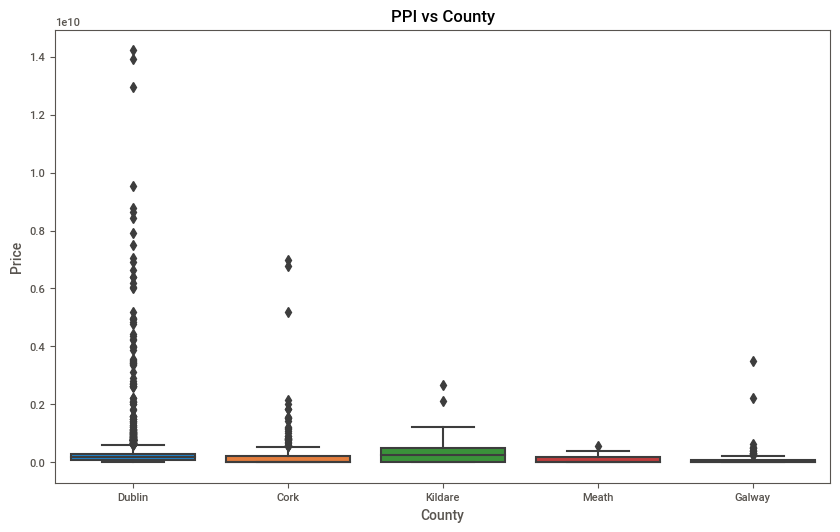

In [60]:
plt.figure(figsize=(10,6))
sns.boxplot(x='County', y='Price', data=df_outlier_svm)
plt.title('PPI vs County')
plt.show()

In [61]:
# I am setting 2 million as threshold here

df_outlier_svm_low = df_outlier_svm[df_outlier_svm['Price'] <= 2000000]
print('houses highlighted as outlier below 2 million price: '+str(df_outlier_svm_low.shape))
df_outlier_svm_low.head()

houses highlighted as outlier below 2 million price: (662, 15)


date_of_sale                                           Address  County  \
279    2010-01-18            30 Chapel Grove, Balbriggan, Co Dublin  Dublin   
586    2010-01-28  97 Great William O'Brien Street, Blackpool, Cork    Cork   
1204   2010-02-18                                Wyanstown, Oldtown  Dublin   
1405   2010-02-25                         99, Kilcairn Court, Navan   Meath   
1619   2010-03-04            49a Leinster Road, Rathmines, Dublin 6  Dublin   

          Price VAT Exclusive Not Full Market Price  \
279   1000000.0            No                   Yes   
586    600000.0            No                    No   
1204   635000.0            No                    No   
1405  1500000.0            No                   Yes   
1619  1000000.0            No                    No   

                    Description of Property    Month county_compare  \
279   Second-Hand Dwelling house /Apartment  2010-01         Dublin   
586   Second-Hand Dwelling house /Apartment  2010-01            NND   
1204  Second-Hand Dwelling house /Apartment  2010-02         Dublin   
1405  Second-Hand Dwelling house /Apartment  2010-02            NND   
1619  Second-Hand Dwelling house /Apartment  2010-03         Dublin   

                           Type of Residential Property  VALUE _merge  year  \
279                 Dublin - all residential properties   96.1   both  2010   
586   National excluding Dublin - all residential pr...  135.3   both  2010   
1204                Dublin - all residential properties   93.9   both  2010   
1405  National excluding Dublin - all residential pr...  133.7   both  2010   
1619                Dublin - all residential properties   91.8   both  2010   

      selling_price  one_svm_outlier  
279    1.286160e+06             True  
586    6.470067e+05             True  
1204   8.358466e+05             True  
1405   1.636874e+06             True  
1619   1.346405e+06             True

In [62]:
df_outlier_svm_high = df_outlier_svm[df_outlier_svm['Price'] >= 2000000]
print('houses highlighted as outlier above 2 million price: '+str(df_outlier_svm_high.shape))
df_outlier_svm_high.head()

houses highlighted as outlier above 2 million price: (1673, 15)


date_of_sale                                            Address   County  \
592    2010-01-28                 Woodburn, 31 Sydney Ave, Blackrock   Dublin   
872    2010-02-05                   SORRENTOVILLE, VICO ROAD, DALKEY   Dublin   
1173   2010-02-18  30 Apts and One Commercial Unit, Sutton Court,...     Cork   
1198   2010-02-18                Ashleigh House, Corbally, Celbridge  Kildare   
1304   2010-02-22            Rosewarne, Glenamuck Road, Carrickmines   Dublin   

            Price VAT Exclusive Not Full Market Price  \
592   260000000.0            No                    No   
872   240000000.0            No                    No   
1173  456387665.0           Yes                    No   
1198  232500000.0            No                    No   
1304  215000000.0            No                    No   

                    Description of Property    Month county_compare  \
592   Second-Hand Dwelling house /Apartment  2010-01         Dublin   
872   Second-Hand Dwelling house /Apartment  2010-02         Dublin   
1173          New Dwelling house /Apartment  2010-02            NND   
1198  Second-Hand Dwelling house /Apartment  2010-02            NND   
1304  Second-Hand Dwelling house /Apartment  2010-02         Dublin   

                           Type of Residential Property  VALUE _merge  year  \
592                 Dublin - all residential properties   96.1   both  2010   
872                 Dublin - all residential properties   93.9   both  2010   
1173  National excluding Dublin - all residential pr...  133.7   both  2010   
1198  National excluding Dublin - all residential pr...  133.7   both  2010   
1304                Dublin - all residential properties   93.9   both  2010   

      selling_price  one_svm_outlier  
592    3.344017e+08             True  
872    3.159105e+08             True  
1173   4.980326e+08             True  
1198   2.537154e+08             True  
1304   2.830032e+08             True

**So we got  outliers both that are low in price and both with high price seperately**

Obviously, I am not saying that the algorithm is perfect and right, but would need a fine tuning ahead for improvement but should solve the case.

We can save both files seperately (df.to_csv('file_name')) and send them to CLient for further investigation.


**Note:** Now, I have ran the outlier detection algo on entire dataset, a more sensible way would be to seperate the dataset, using Dublin vs Rest and then running outlier detection on both seperately, which would give a more sensible outlier split and help model generalize much better, but to avoid complexity I have used entire dataset.


##### 5. Forecasting Stamp Duty

The final client deliverable is an evaluation report which outlines the suitability of using a model, which can forecast monthly stamp duty.

For the evaluation report, please provide the following sections:

* Methodology - description of methodology and selection considerations.
* Evaluation - evaluation of model with comments.
* Summary of Findings - provide the client with a summary of your outcome findings and suggested future steps.

The Revenue have provided the following stamp duty formula.

$$
\text{Stamp Duty Due} = \text{Stamp Duty Rate} \times (\text{Sale Price}-(\text{Sale Price} \times \text{VAT}))
$$

where, **Stamp Duty Rate** is assumed to be 1% for all sales and **VAT** is 13.5%.

Limit the evaluation to the data output from part 2 in the case study.

I will split this section into 2 parts:



1.   Calculating Stamp Duty price
2.   Forecasting Stamp Duty price




**1. Calculating Stamp Duty**

I have written a function to calculate stamp duty, using formulae defined above, using lambda function applying the calculation on entire dataset becomes very easy.

In [63]:
def forecast_stamp_duty(sale_price):
  return 0.01*(sale_price - (sale_price*0.13))

print('Shape of dataframe before applying stamp duty calculation: '+str(df_merge.shape))
df_merge['stamp_duty'] = df_merge.apply(lambda x: forecast_stamp_duty(x['selling_price']),axis=1) 
print('Shape of dataframe after applying stamp duty calculation: '+str(df_merge.shape))
df_merge.head()

Shape of dataframe before applying stamp duty calculation: (233835, 15)
Shape of dataframe after applying stamp duty calculation: (233835, 16)


date_of_sale                                 Address  County       Price  \
0   2010-01-01  5 Braemor Drive, Churchtown, Co.Dublin  Dublin  34300000.0   
1   2010-01-04     1 Meadow Avenue, Dundrum, Dublin 14  Dublin  43850000.0   
2   2010-01-04                 1 The Haven, Mornington   Meath  40000000.0   
3   2010-01-04          12 Sallymount Avenue, Ranelagh  Dublin  42500000.0   
4   2010-01-04   15 Carriglawn, Waterpark, Carrigaline    Cork  18000000.0   

  VAT Exclusive Not Full Market Price                Description of Property  \
0            No                    No  Second-Hand Dwelling house /Apartment   
1            No                    No  Second-Hand Dwelling house /Apartment   
2            No                    No  Second-Hand Dwelling house /Apartment   
3            No                    No  Second-Hand Dwelling house /Apartment   
4            No                    No  Second-Hand Dwelling house /Apartment   

     Month county_compare                       Type of Residential Property  \
0  2010-01         Dublin                Dublin - all residential properties   
1  2010-01         Dublin                Dublin - all residential properties   
2  2010-01            NND  National excluding Dublin - all residential pr...   
3  2010-01         Dublin                Dublin - all residential properties   
4  2010-01            NND  National excluding Dublin - all residential pr...   

   VALUE _merge  year  selling_price  one_svm_outlier     stamp_duty  
0   96.1   both  2010   4.411530e+07            False  383803.080125  
1   96.1   both  2010   5.639813e+07            False  490663.704475  
2  135.3   both  2010   4.313378e+07            False  375263.858093  
3   96.1   both  2010   5.466181e+07            False  475557.752341  
4  135.3   both  2010   1.941020e+07            False  168868.736142

**2. Forecasting Stamp Duty Price**


**2.1 Methodology:**

> We will need to design a Regression model, that will predict stamp duty price given previous stamp duty price and features which will help to predict the stamp duty price.



> In Regression task, we need to predict a value instead of class unlike classification, though both fall under supervised machine learning task. Linear Regression been most popular and easy to implement regression algorithm.



> However, given our situation where we know our dataset has outliers in it and would add up to bias in model prediction, so we need a more robust algorithm which takes into consideration the presence of outliers in training data and deal accordingly.

**2.2 Selection criteria of features and Model**


**2.2.1 Feature selection:**


> Data Encoding: I need to get my dataset into format that my ML model can understand, this involves encoding categorical variables into numerical format.
Now I will be using one-hot encoding instead of label encoder, cause label encoder will assign value of 0,1,2,3 to categories and in calculation model may give more importance to value 3 then one with 1 and that is fine for ordinal cases but not in our cases where say every county should get equal importance.

> Dataset columns used in one-hot encoding for categorical features ['County','VAT Exclusive','Not Full Market Price','Description of Property','Type of Residential Property','year']
Dataset columns used as it is:  ['VALUE','Price','selling_price']



> Though selling price is derived from Price, there will be a high collinearity between the two columns but selling price is used for calculating stamp price so better to use it in base model and then use feature ranking where we can drop a feature if it dsnt add much value to model development.

**2.2.2 Gradient Boosting Regression**


> Gradient Boosting trains many models in a gradual, additive and sequential manner. The major difference between AdaBoost and Gradient Boosting Algorithm is how the two algorithms identify the shortcomings of weak learners (eg. decision trees). While the AdaBoost model identifies the shortcomings by using high weight data points, gradient boosting performs the same by using gradients in the loss function (y=ax+b+e , e needs a special mention as it is the error term). The loss function is a measure indicating how good are model’s coefficients are at fitting the underlying data. A logical understanding of loss function would depend on what we are trying to optimise. We are trying to predict the sales prices by using a regression, then the loss function would be based off the error between true and predicted house prices.






In [64]:
# Instead of recreating dataset all over again, we will be using the one that 
# we created for outlier detection above. All features used for input dataset
# are mentioned above.
data= concatenated_data.values
print(data.shape)

(233835, 15)


In [65]:
# we will be using 'stamp_duty' values as labels or expected output
y = df_merge['stamp_duty'].values
y.shape

(233835,)

In [66]:
# spliting dataset into train-test, as our dataset is big, even 10% for testing should be enough for evaluation
X_train, X_test, y_train, y_test= train_test_split(data,y, test_size=0.1)

print('Training dataset size: '+str(X_train.shape))
print('Testing dataset size: '+str(X_test.shape))

Training dataset size: (210451, 15)
Testing dataset size: (23384, 15)


In [67]:
# training gradient boosting algorithm

params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor()

clf.fit(X_train, y_train)
clf_pred=clf.predict(X_test)
print(clf_pred)

[154665.93246247 113531.80040202 512976.9260792  ... 142047.17597902
 224404.8191669  287253.05193492]


**Model Evaluation**

Regression is a predictive problem where we predict a numeric value.

Unlike classification, where we use accuracy as evaluation criteria to predict model performance. 
Instead, we must use error metrics for evaluating regression.

We will be using 4 error metrics for evaluating performance of a regression model.



1.  Mean Squared Error (MSE)





    1 / N * sum for i to N (y_i – yhat_i)^2

    Where y_i is the i’th expected value in the dataset, yhat_i is the i’th predicted value

2.  Root Mean Squared Error (RMSE)



    RMSE = sqrt(MSE)
    
3.  Mean Absolute Error (MAE)
  
  
    MAE = 1 / N * sum for i to N abs(y_i – yhat_i)


4.  R-squared (R2)


    R2 = 1- (Square_Sum_error_regression_line/Square_sum_error_mean_line)


In [68]:
# Evaluate model performance on testing data
#clf_pred= clf_pred.reshape(-1,1)
#print(clf_pred)
print('MAE:', mean_absolute_error(y_test, clf_pred))
print('MSE:', mean_squared_error(y_test, clf_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, clf_pred)))
print('R-squared: ', r2_score(y_test,clf_pred))

MAE: 4750.417125072067
MSE: 2163433907.1021895
RMSE: 46512.728441816755
R-squared:  0.9978920401925052


**Let us have a glimpse at actual value vs Predicted value to understand how well or poor our model has performed**

In [69]:
pd.options.display.float_format = '{:20,.2f}'.format

df_eva = pd.DataFrame(list(zip(y_test, clf_pred)),
               columns =['Actual Stamp Duty', 'Predicted Stamp Duty'])
print(df_eva.shape)
df_eva.head(10)

(23384, 2)


Actual Stamp Duty  Predicted Stamp Duty
0           154,976.34            154,665.93
1           109,358.02            113,531.80
2           503,798.16            512,976.93
3           279,909.78            281,502.34
4            85,713.91             85,822.72
5            67,710.61             68,738.14
6           230,230.43            227,422.13
7           303,449.76            307,132.51
8           419,228.07            418,820.37
9           267,781.22            265,659.94

Not too bad, with model tunning our model performance could get even better.

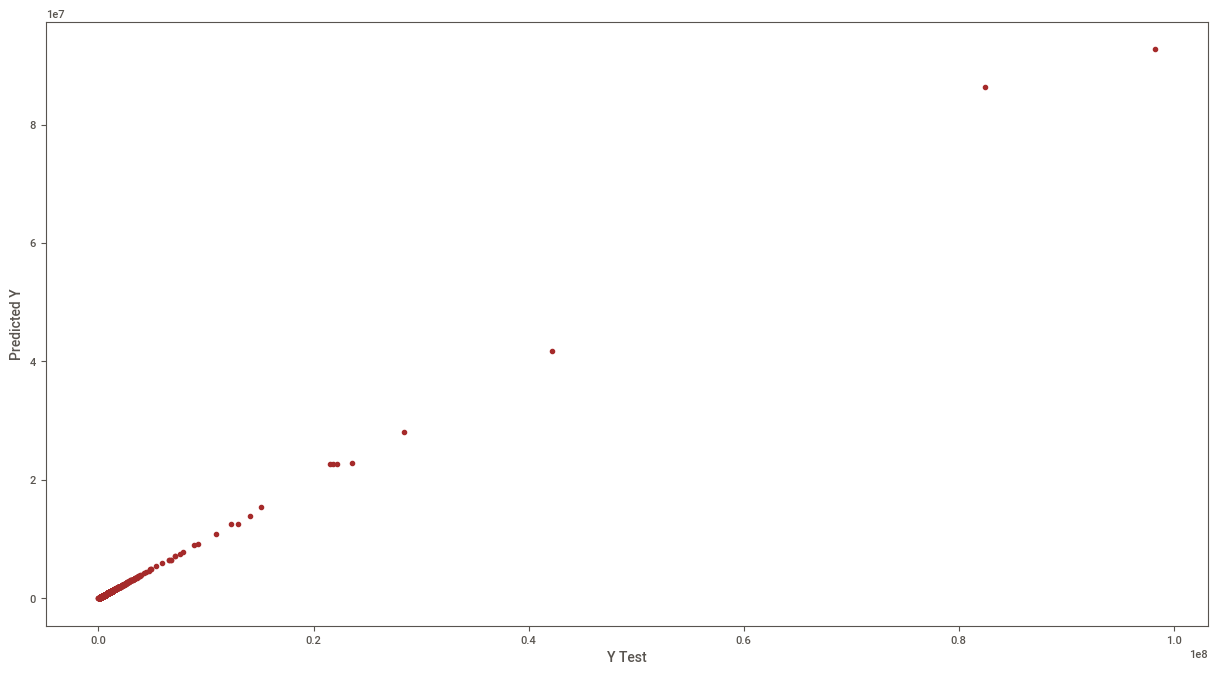

In [70]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,clf_pred, c= 'brown')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

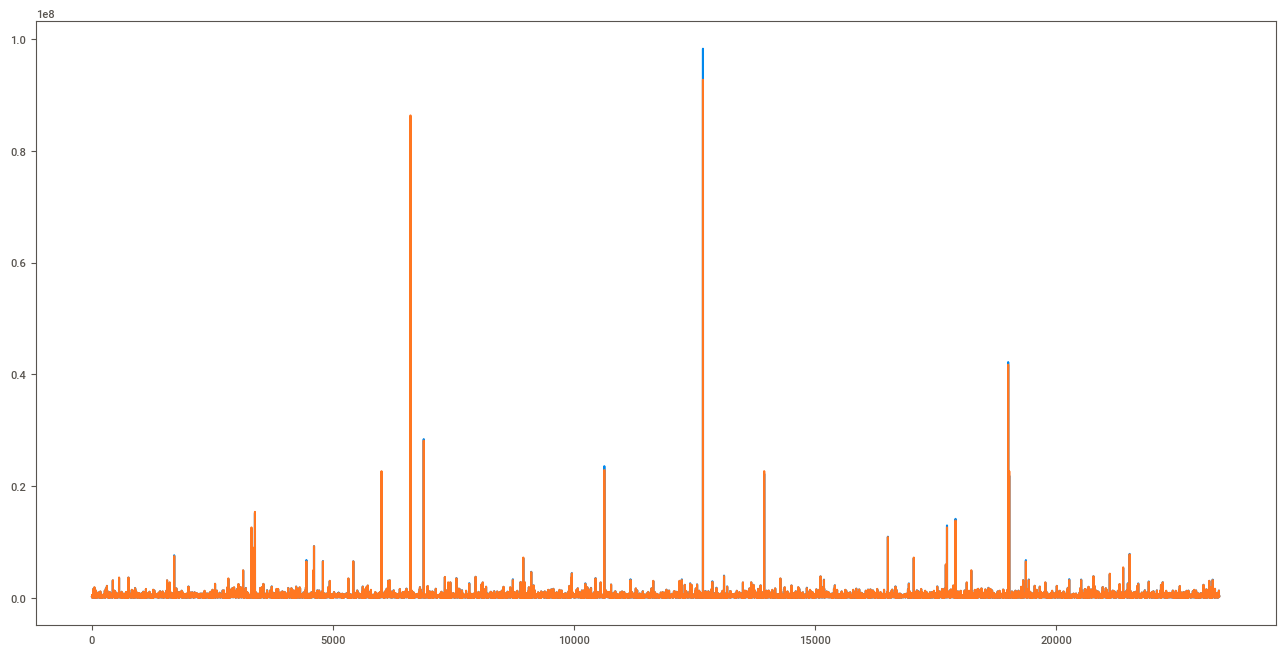

In [71]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(clf_pred, label = 'predict')
plt.show()


## Model Explanability

In [96]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(X_train, mode="regression", feature_names= features)
explainer

In [99]:
import random
idx = random.randint(1, len(X_test))

print("Prediction : ", clf.predict(X_test[idx].reshape(1,-1)))
print("Actual :     ", y_test[idx])

explanation = explainer.explain_instance(X_test[idx], clf.predict, num_features=len(features))
explanation

Prediction :  [237943.51802254]
Actual :      233089.5953757225


In [100]:
explanation.show_in_notebook()


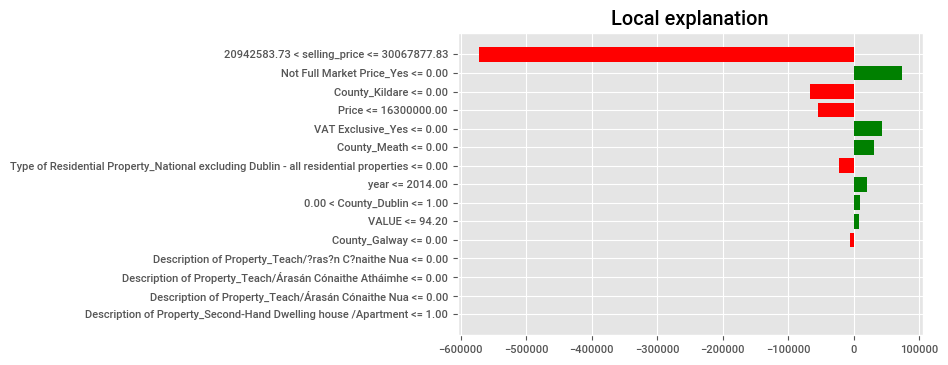

In [101]:
with plt.style.context("ggplot"):
    explanation.as_pyplot_figure()

**Summary, Suggestions and Future Steps:**


Considering the above model as base model to evaluation, we performed well.

The results are not accurate but they are not far off from actual value, which means we are on right track.

Though, this is just the start and there are loads of changes that could be done to make it even better.


Now things to look out for and do,

1. we need to remove the outliers from training dataset to improve our model generalizing power.

2. Try more algorithms to see how they perform on given dataset.
  (XGBOOST Regressor, Lasso Regression, Elastic Net Regression, Gradient Boosting Regression, LGBM Regressor, etc....)

3. Define cross-validation strategy with shuffle along with evaluation metric from above like RMSE to improve model performance on unseen data.

4. Define hyper-parameter tunning or optimization strategy like [Grid Search, Random Search, Bayesian Optimization] for further improvements.

5. Add a sklearn pipeline before training model, where our data is passed through RobustScalar() (Normalizing or Standardizing Price and Value) model which would remove if any noise present and make data smooth for model training and prediction.

6. Try developing models specific to counties of importance, say Dublin only model for better accuracy.

7. Use Feature importance strategy to find top features which impact in model decision.

8. Try Neural network (Deep Learning) if that is an option, as we have enormous amount of data suitable for training deep learning models. 